    ДИПЛОМНЫЙ ПРОЕКТ
 «Модель прогнозирования стоимости жилья для агентства недвижимости»

    Задача: 
разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок - предсказание цены объекта недвижимого имущества.
 
    Описание данных:
 'status' — статус продажи;
 'private pool' и 'PrivatePool' — наличие собственного бассейна;
 'propertyType' — тип объекта недвижимости;
 'street' — адрес объекта;
 'baths' — количество ванных комнат;
 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
 'fireplace' — наличие камина;
 'city' — город;
 'schools' — сведения о школах в районе;
 'sqft' — площадь в футах;
 'zipcode' — почтовый индекс;
 'beds' — количество спален;
 'state' — штат;
 'stories' — количество этажей;
 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).


In [568]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

In [569]:
# from ydata_profiling import ProfileReport
# import dtale

1. Разведывательный анализ и очистка данных

In [570]:
df=pd.read_csv('data.csv')
df.head(2)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"


In [571]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [572]:
df.describe(include='object')

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


In [573]:
# процентное отношение пропущенных значений в каждом столбце 
cnp = df.isnull().mean() * 100
cwn= cnp[cnp>0].sort_values(ascending=False)
display(cwn)

private pool    98.891525
mls-id          93.387330
PrivatePool     89.312672
fireplace       72.661956
stories         39.957846
baths           28.192532
beds            24.200856
MlsId           17.731352
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
dtype: float64

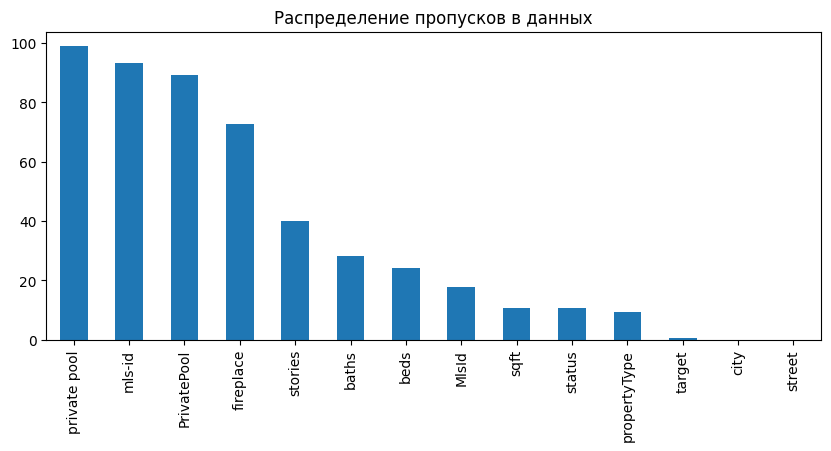

In [574]:
# столбчатая диаграмма пропусков
cwn.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

<AxesSubplot: >

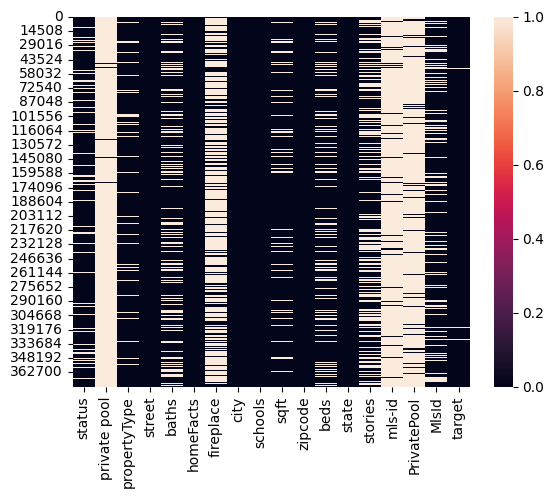

In [575]:
sns.heatmap(df.isnull()) # наглядная карта пропусков

In [576]:
data=df.copy()

In [577]:
# для первичной визуализации и знакомства с данными применим автоматический отчет
# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile # запускала в отдельном файле 

In [578]:
# считаем сколько строк с пропусками т - количество пропусков столбцов из 18 
m = 8
df_with_na = df[df.isnull().sum(axis=1) > m]
print(df_with_na.shape)
# процент строк с т пропусками к общему количеству строк датасета
print(len(df_with_na)*100/len(df))
# удалим строки с 8 пропусками
df = df.dropna(thresh=(df.shape[1]-m))
print(df.shape)


(16200, 18)
4.294974614579052
(360985, 18)


In [579]:
# посчитаем дубликаты
duplicate_rows = df[df.duplicated()]
print(duplicate_rows.shape)
# удаляем дубликаты
df=df.drop_duplicates(keep='first')

(49, 18)


In [580]:
# процентное отношение пропущенных значений в каждом столбце 
cnp = df.isnull().mean() * 100
cwn= cnp[cnp>0].sort_values(ascending=False)
display(cwn)

private pool    98.841623
mls-id          93.089634
PrivatePool     88.831815
fireplace       71.433994
stories         37.259237
baths           24.968138
beds            21.724904
MlsId           18.296873
status          10.172995
sqft             6.778210
propertyType     5.293459
target           0.534721
city             0.009143
street           0.000277
dtype: float64

Вывод: 
Минимальное количество пропусков в улице и городе, мы их можем удалять?, доля незначительна . 
Большое количество пропусков : private pool,mls-id,PrivatePool,fireplace, stories. Как правило такие данные рекомендются к удалению, но мы попробуем их обработать.    
     

Столбец city и street

In [581]:
# удаляем  строки с пропусками в столбцах город м улица
df = df.dropna(subset=['city', 'street'], axis=0)

In [582]:
null_values = df['city'].isnull().sum()
zero_values = len(df[df['city'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")


Количество пропущенных значений: 0
Количество нулевых значений: 0


In [583]:
abbreviations = ['st', 'dr', 'ave', 'rd', 'ln', 'n', 'w', 'ct', 's', 'sw', 'dr', 'pl', 'blv', 'blvd', 'hwy', 'hi', 'prwy', 'pde', 'tce']
import re
def categorize_street(street):
    if any(word in street.lower() for word in ['undisclosed', 'mls']):
        return 'undisclosed'
    elif any(word in street.lower() for word in ['unknown', 'address not']):
        return 'unknown'
    elif len(street.strip()) == 0:  # Проверка на пустую строку
        return 'unknown'
    else:
        stripped_street = street.strip()
        
        # Удаляем число в начале строки или число и одну отдельную букву после числа
        pattern = r'^\d+\s+|\d+\s+[A-Za-z]\s?'
        stripped_street = re.sub(pattern, '', stripped_street).strip()
        
        # удаляем букву в начале строки, которая осталась от номера дома
        pattern =r'^[A-Za-z]\s'   
        stripped_street = re.sub(pattern, '', stripped_street).strip()
        
        # Удаляем все после : #, APT, Unit
        pattern = r'#[^\s]+|APT\s?\S+|Unit\s?\S+|Lot\s?\S+'
        stripped_street = re.sub(pattern, '', stripped_street).strip()
        
        # Удаляем символы после /
        pattern = r'\/\S+'
        stripped_street = re.sub(pattern, '', stripped_street).strip()
        
        # Проверяем, содержит ли улица слово 'plan'
        if 'plan' in stripped_street.lower():
            return 'buildable plan'
        
        return stripped_street
        
    return ''

df['street_category'] = df['street'].apply(categorize_street)

Столбец homeFacts
десериализуем, получим новые данные : 
- Year built
- Remodeled year
- Heating
- Cooling
- Parking
- Lot size
- Price per square foot

In [584]:
# десереализуем столбец с помощью функцмм
def deserialize_home_facts(row):
    home_facts_dict = eval(row) # преобразования строки в словарь
    return home_facts_dict['atAGlanceFacts']

df['homeFacts'] = df['homeFacts'].apply(deserialize_home_facts)


In [585]:
# создадим новые столбцы на основе данных
df['Year built'] = df['homeFacts'].apply(lambda x: x[0]['factValue'] if x[0]['factLabel'] == 'Year built' else None)
df['Remodeled year'] = df['homeFacts'].apply(lambda x: x[1]['factValue'] if x[1]['factLabel'] == 'Remodeled year' else None)
df['Heating'] = df['homeFacts'].apply(lambda x: x[2]['factValue'] if x[2]['factLabel'] == 'Heating' else None)
df['Cooling'] = df['homeFacts'].apply(lambda x: x[3]['factValue'] if x[3]['factLabel'] == 'Cooling' else None)
df['Parking'] = df['homeFacts'].apply(lambda x: x[4]['factValue'] if x[4]['factLabel'] == 'Parking' else None)
df['Lot size'] = df['homeFacts'].apply(lambda x: x[5]['factValue'] if x[5]['factLabel'] == 'lotsize' else None)
df['Price per square foot'] = df['homeFacts'].apply(lambda x: x[6]['factValue'] if x[6]['factLabel'] == 'Price/sqft' else None)

In [586]:
df[['Year built','Remodeled year','Heating','Cooling','Parking','Lot size','Price per square foot']].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 360902 entries, 0 to 377184
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Year built             360311 non-null  object
 1   Remodeled year         337435 non-null  object
 2   Heating                360345 non-null  object
 3   Cooling                360345 non-null  object
 4   Parking                360345 non-null  object
 5   Lot size               335553 non-null  object
 6   Price per square foot  317980 non-null  object
dtypes: object(7)
memory usage: 22.0+ MB


In [587]:
df=df.drop('homeFacts', axis=1)


In [588]:
# столбец Year built
df['Year built'] = pd.to_datetime(df['Year built'], errors='coerce').dt.year
df['Year built'].isnull().sum()

48438

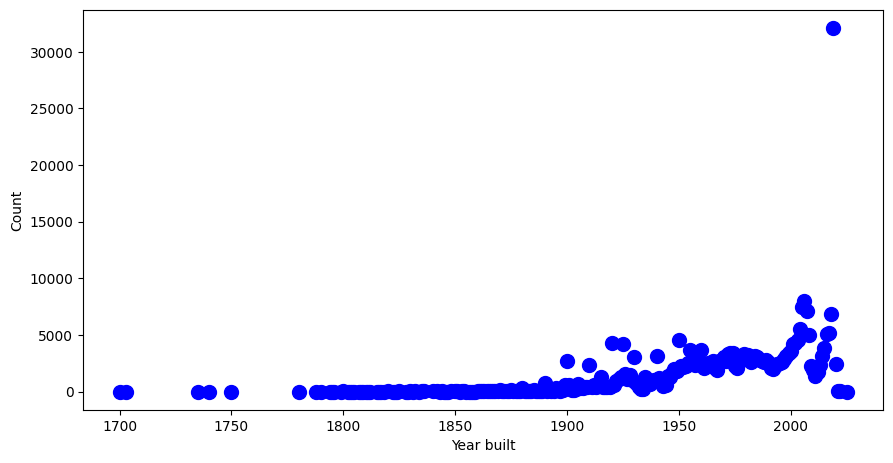

In [589]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
counts = df['Year built'].value_counts()
x_values = counts.index
y_values = counts.values
axes.scatter( x=x_values, y=y_values, s=100, marker='o', c='blue')
axes.set_xlabel('Year built')
axes.set_ylabel('Count')
plt.show()

In [590]:
# обработаем столбец реновации
df['Remodeled year']=pd.to_datetime(df['Remodeled year'], errors='coerce').dt.year

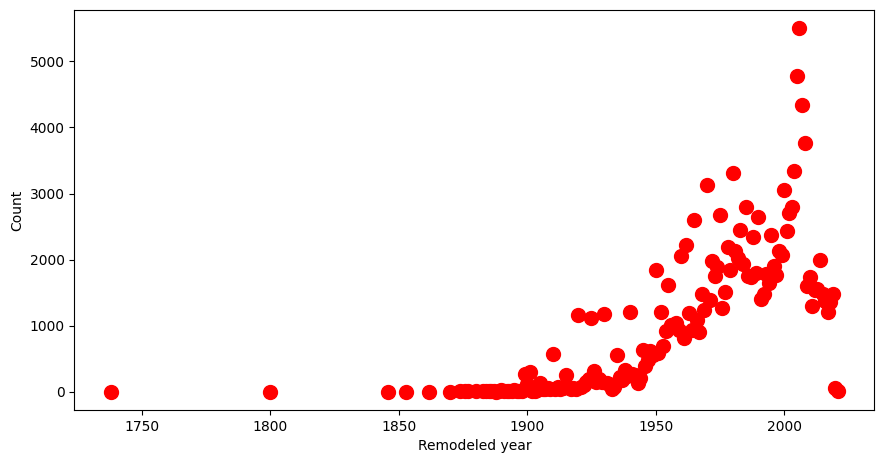

In [591]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
counts = df['Remodeled year'].value_counts()
x_values = counts.index
y_values = counts.values
axes.scatter( x=x_values, y=y_values, s=100, marker='o', c='red')
axes.set_xlabel('Remodeled year')
axes.set_ylabel('Count')
plt.show()

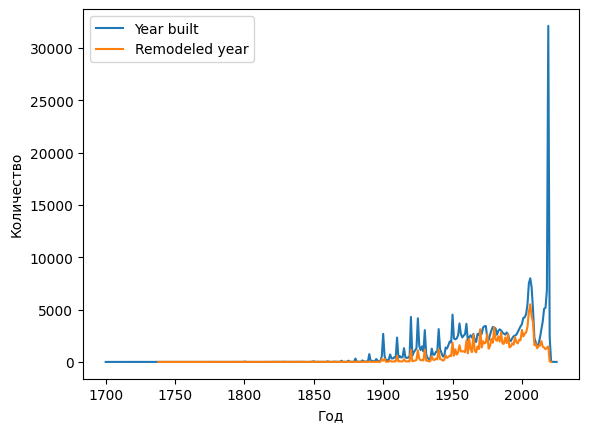

In [592]:
# график для года постройки и реновации - практически совпадают
fig, ax = plt.subplots()
#  данные для столбца Year built
df['Year built'].value_counts().sort_index().plot(ax=ax, label='Year built')
# данные для столбца Remodeled year
df['Remodeled year'].value_counts().sort_index().plot(ax=ax, label='Remodeled year')
# метки осей и легенда
ax.set_xlabel('Год')
ax.set_ylabel('Количество')
ax.legend()
plt.show()

In [593]:
# заполняем нулевые значения года постройки из столбца реновации
df['Year built'].fillna(df['Remodeled year'], inplace=True)

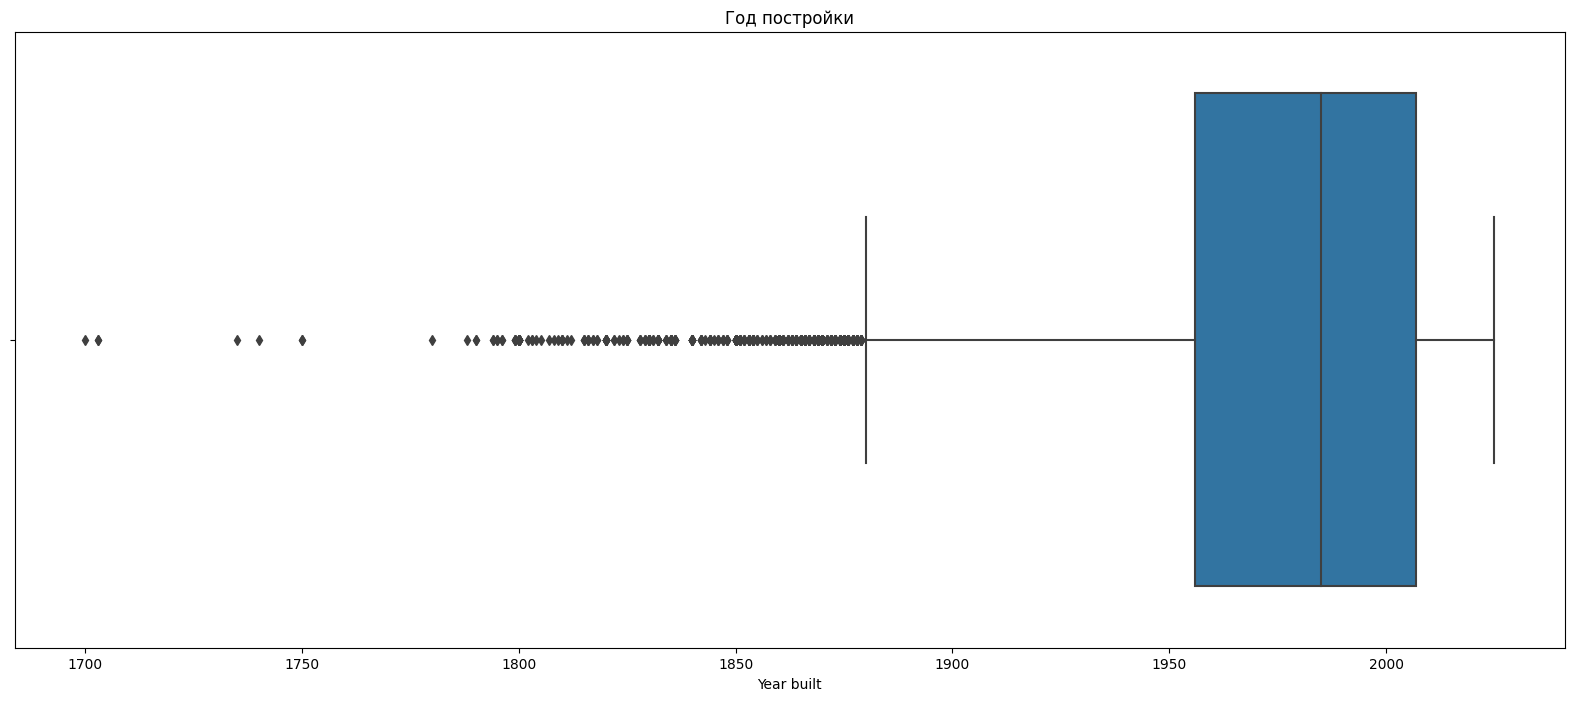

In [594]:
# смотрим выбросы, они есть
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='Year built', ax=axes[1])
boxplot.set_title('Год постройки')
plt.show()

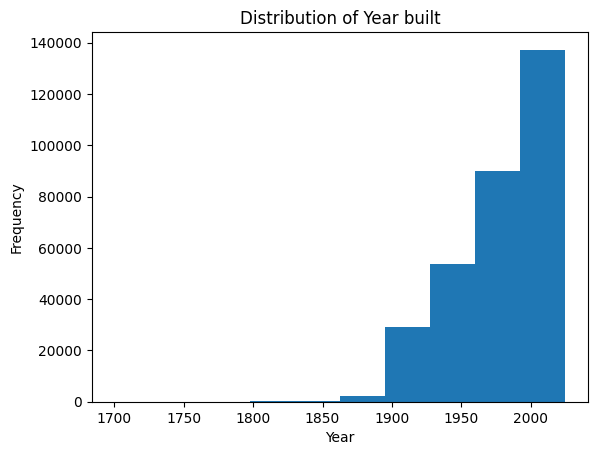

In [595]:

plt.hist(df['Year built'], bins=10)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Year built')
plt.show()

In [596]:
# смотрим, какие объекты с годом постройки до 1870 года
err_min=df[df['Year built']<1870]
print(err_min)


          status private pool        propertyType  \
1004    for sale          NaN  single-family home   
1212    for sale          NaN           townhouse   
1436    For sale          NaN               Condo   
1784    For sale          NaN        Multi Family   
2064    For sale          Yes       Single Family   
...          ...          ...                 ...   
371982  for sale          NaN        multi-family   
373898  for sale          NaN               condo   
373929    Active          NaN  Single Family Home   
374538  for sale          NaN  single-family home   
377033  for sale          NaN               condo   

                             street          baths     fireplace  \
1004            400 E Evergreen Ave        4 Baths           yes   
1212               2031 Delancey St        7 Baths           yes   
1436            134 Beacon St # 201   Bathrooms: 4           NaN   
1784                 1036 Dayton St            NaN           NaN   
2064                   

мы можем не удалять строки с годом более 2022 года, т.к. есть объекты в строящихся домах, в столбце status есть информация coming soon, но для простоты все же удалим их и будем иметь ввиду для улучшения моделирования.
Дома 1700-1870 года постройки и подобные есть в наличии, их 473 шт, доля маленькая не репрезентативная,  удаляем как выбросы. 

In [597]:
# удалим  строящиеся объекты  
# но в столбце статус продажи  встречается информация о объектах которые coming soon
df = df[df['Year built'] <= 2022]

In [598]:
df=df[df['Year built']>=1870]

In [599]:
# функция для метода z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
# применим функцию для нашего датафрэйма для столбца Year built
outliers, cleaned = outliers_z_score(df, 'Year built', log_scale=True)
df = cleaned
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')


Число выбросов по методу z-отклонения: 675
Результирующее число записей: 311658


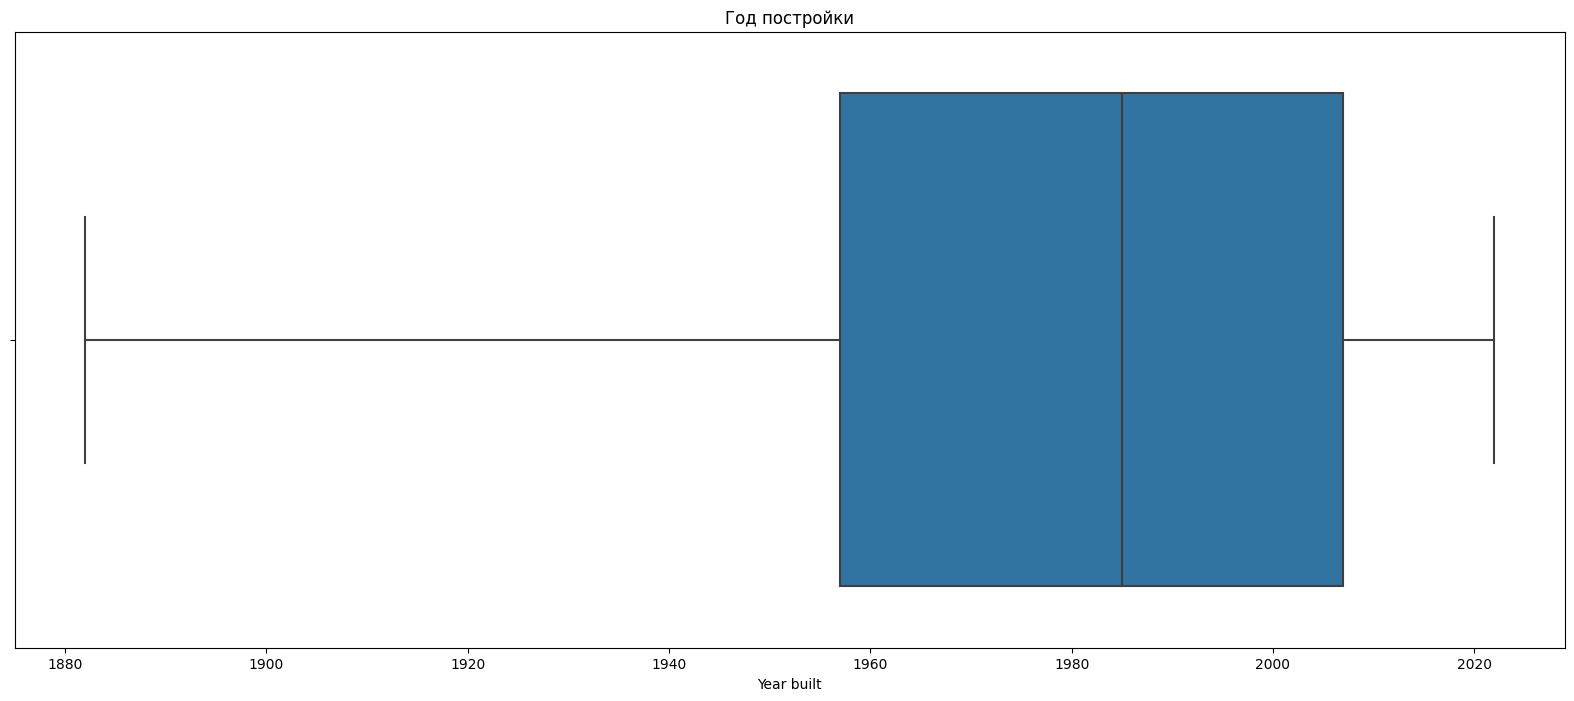

In [600]:
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='Year built', ax=axes[1])
boxplot.set_title('Год постройки')
plt.show()

In [601]:
df['Year built']=df['Year built'].astype(int)

In [602]:
null_values = df['Year built'].isnull().sum()
zero_values = len(df[df['Year built'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 0
Количество нулевых значений: 0


In [603]:
null_values = df['Remodeled year'].isnull().sum()
zero_values = len(df[df['Remodeled year'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 162454
Количество нулевых значений: 0


заполним пропуски нулями, т.к. нет информации о сроках обязательной реновации в открытых источниках,
будем считать, что если нет информации, то реновацию не делали
В данных много пропусков == нулей, поэтому используем  метод межквартильного расстояния (IQR) для определения выбросов

In [604]:
Q1 = df['Remodeled year'].quantile(0.25)
Q3 = df['Remodeled year'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Remodeled year'] < lower_bound) | (df['Remodeled year'] > upper_bound)]
cleaned = df[(df['Remodeled year'] >= lower_bound) & (df['Remodeled year'] <= upper_bound)]
df=cleaned
print(f'Число выбросов по методу IQR: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')


Число выбросов по методу IQR: 1869
Результирующее число записей: 147335


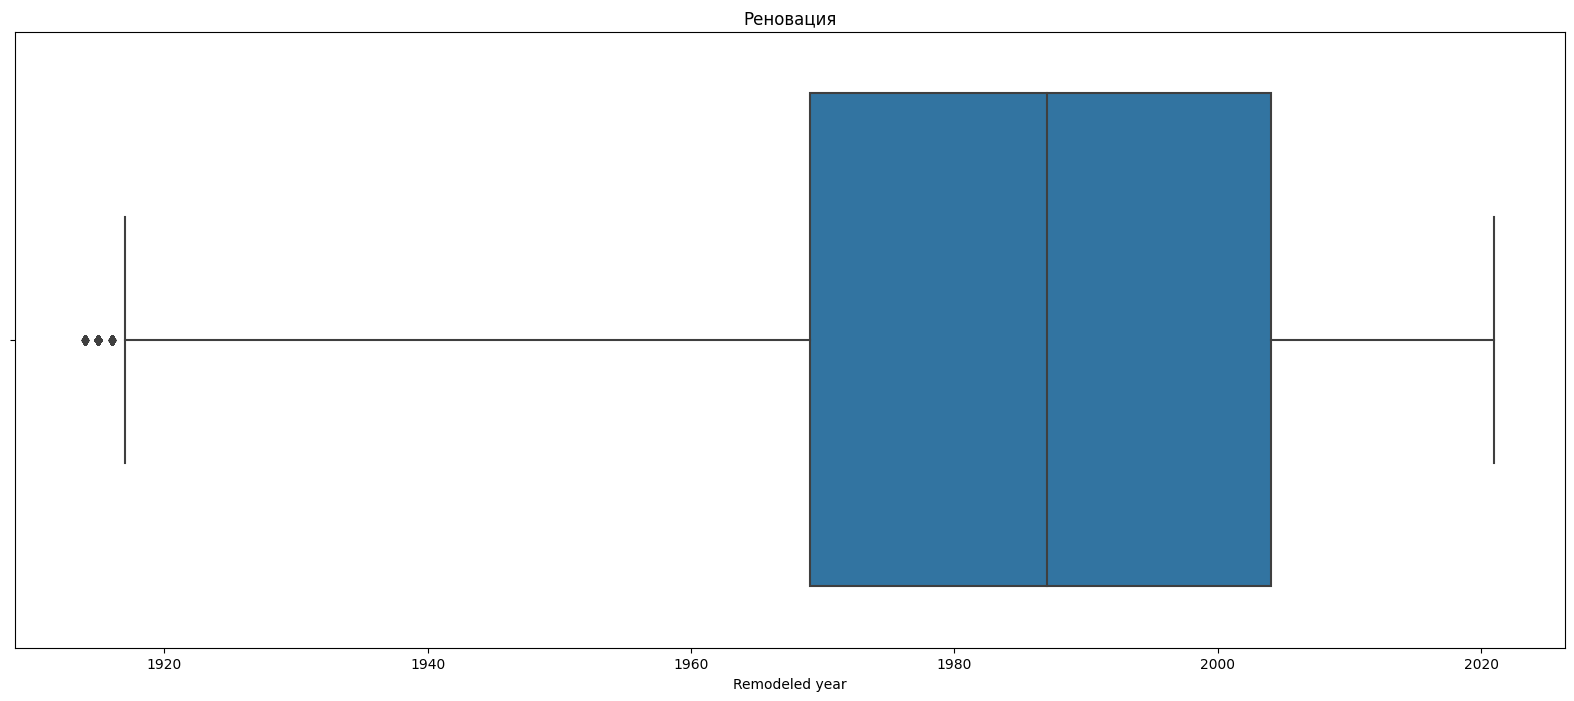

In [605]:
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='Remodeled year', ax=axes[1])
boxplot.set_title('Реновация')
plt.show()

In [606]:
df['Remodeled year']=df['Remodeled year'].fillna(0) # заменим пробелы нулями
df=df[df['Remodeled year']>=1910] # удалим выбросы
df['Remodeled year']=df['Remodeled year'].astype(int) # меняем тип
df['Remodeled year'].value_counts()

2006    5499
2005    4772
2007    4330
2008    3755
2004    3339
        ... 
2020      48
1933      47
1919      37
1917      34
2021       6
Name: Remodeled year, Length: 108, dtype: int64

столбец Parking

In [607]:
# даем ориентиры для обработки по аналогии столбцов
conditions = [
    (df['Parking'].isna()) | (df['Parking'].str.contains('Attached Garage|Detached Garage|Detached|2 spaces|1 space|Side Load Garage', case=False)),
    (df['Parking'].isna()) | (df['Parking'].str.contains('Under Building|Assigned Parking Space|Parking Garage|Paved Parking|Carport - 3 Car|Golf Carts OK', case=False)),
    (df['Parking'].isna()) | (df['Parking'].str.contains('Deed Restrictions|Special Community Restrictions', case=False)),
    (df['Parking'].isna()) | (df['Parking'].str.contains('None|Basement|Paved Driveway|Off Street|Deed Restrictions|Fitness|Gated Community|No Truck/RV/Motorcycle Parking|Pool', case=False))
]
choices = ['Garage', 'Parking', 'No Parking', 'Restrictions'] # категории столбцов по значению 
df['Parking Category'] = ""                                    # новый столбец с категориями
for i, condition in enumerate(conditions):
    df.loc[condition, 'Parking Category'] = choices[i]
df['Parking Category']=df['Parking Category'].replace('','No Parking')
df=df.drop('Parking', axis=1)
df['Parking Category'].value_counts()

Garage          74076
No Parking      67542
Restrictions     5717
Name: Parking Category, dtype: int64

In [608]:
# столбец  Price per square foot
# создаем столбец Price_sgu_clean прменив резулярные выражения через функцию 
import re
def clean_price(x):
    if isinstance(x, str):
        x = re.sub(r'[$,/sqftSq. Ft.]', '', x) # удаляем символы
        x = re.sub(r'\s+', '', x)
        return x
    return np.nan

df['Price_sgu_clean'] = df['Price per square foot'].apply(clean_price)
# переведем в числовой формат
df['Price_sgu_clean']=pd.to_numeric(df['Price_sgu_clean'],errors='coerce')
df=df.drop('Price per square foot',axis=1)
df['Price_sgu_clean'].value_counts()


135.0     697
115.0     682
128.0     680
111.0     673
125.0     666
         ... 
3958.0      1
1874.0      1
2536.0      1
1759.0      1
1620.0      1
Name: Price_sgu_clean, Length: 2106, dtype: int64

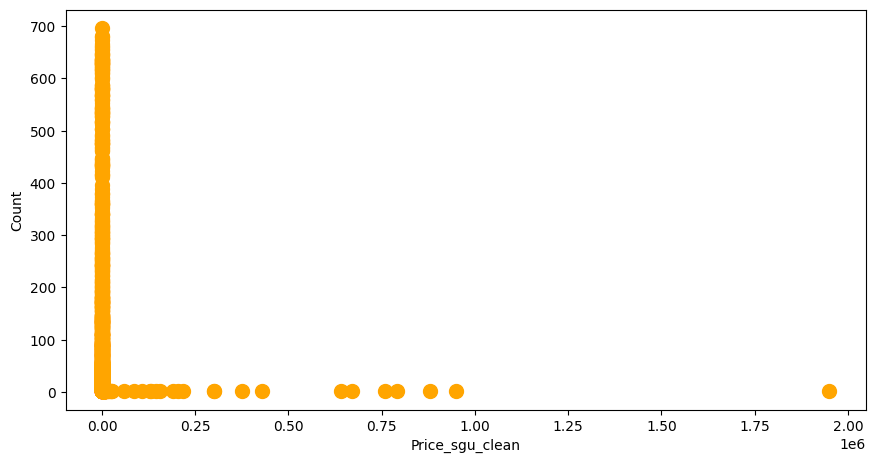

In [609]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
counts = df['Price_sgu_clean'].value_counts()
x_values = counts.index
y_values = counts.values
axes.scatter( x=x_values, y=y_values, s=100, marker='o', c='orange')
axes.set_xlabel('Price_sgu_clean')
axes.set_ylabel('Count')
plt.show()

In [610]:
# удалим явные выбросы 
df = df[df['Price_sgu_clean'] <= 10000]

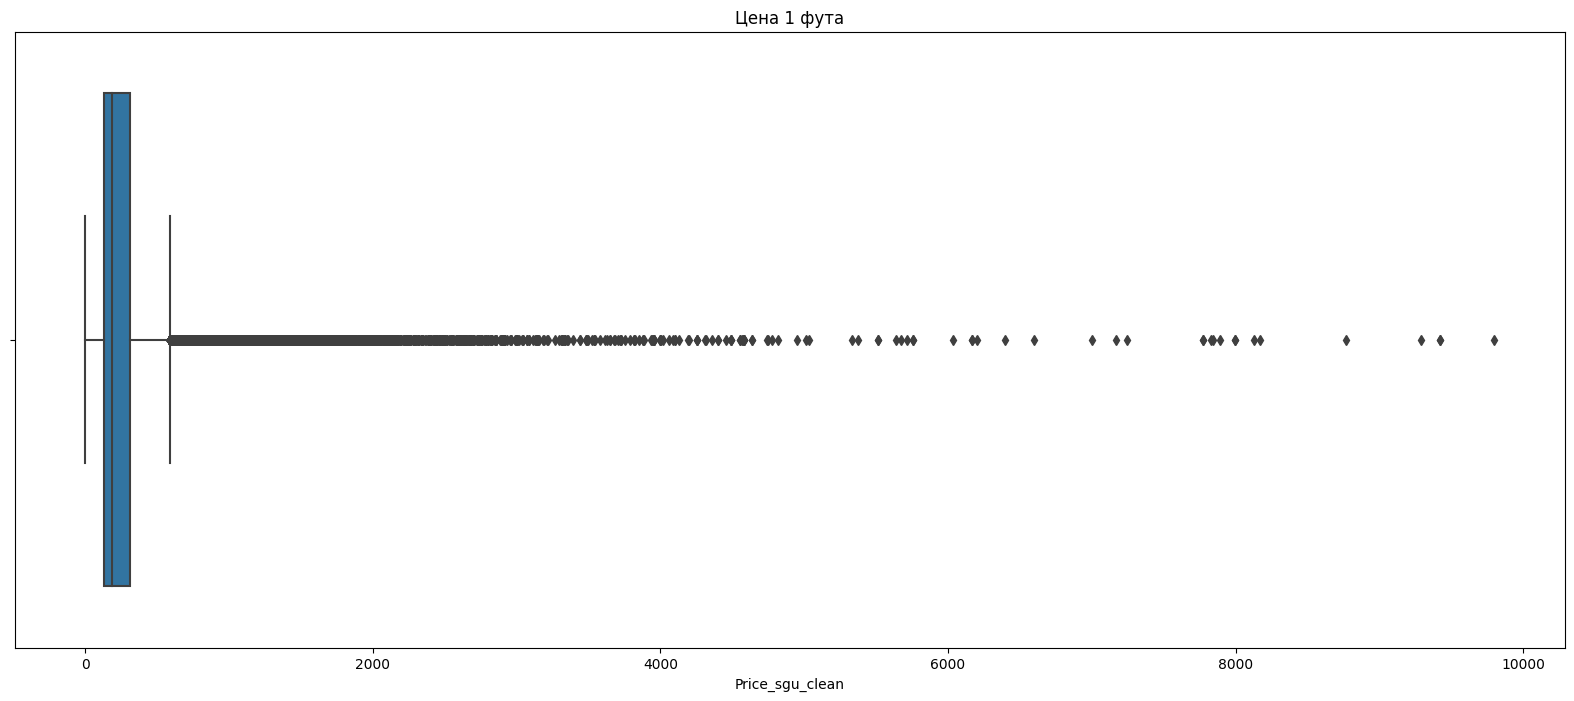

In [611]:
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='Price_sgu_clean', ax=axes[1])
boxplot.set_title('Цена 1 фута')
plt.show()

In [612]:
# смотрим данные со стоимостью метра более 2000,
# выглядит это как выбросы, но мы их оставим, т.к. этот столбец технический 
err_mln=df[df['Price_sgu_clean']>2000]
print(err_mln)


          status private pool         propertyType  \
437     for sale          NaN   single-family home   
2305    for sale          NaN   single-family home   
4494         NaN          NaN                Condo   
7733    for sale          NaN   single-family home   
9351      Active          NaN  Detached, Two Story   
...          ...          ...                  ...   
373623  for sale          NaN             lot/land   
374232  for sale          NaN   single-family home   
374681    Active          NaN                  NaN   
375234  for sale          NaN             lot/land   
376127  for sale          NaN   single-family home   

                              street    baths fireplace             city  \
437               2665 Castilla Isle  9 Baths       yes  Fort Lauderdale   
2305                  1535 Gordon St      NaN       NaN      Los Angeles   
4494           125 Ocean Dr # U-0204      4.0       NaN      Miami Beach   
7733                  109 Webster St      NaN  

In [613]:
# столбуц Heating

def process_heating(x):
    x = str(x).lower() # переводим в строку и нижний регистр 
    if 'electric' in x or 'air' in x or 'heat' in x:
        return 1  # электрическое отопление
    elif 'gas' in x:
        return 2  # газовое отопление
    elif 'water' in x:
        return 3  # водяное отопление
    else:
        return 4  # прочее отопление

df['Heating'] = df['Heating'].apply(process_heating)
df['Heating']=df['Heating'].replace('','4')
df['Heating'].value_counts()

1    95690
4    40910
2     1512
3       25
Name: Heating, dtype: int64

In [614]:
# столбуц Cooling
# функция для перебора 
def process_cooling(x):
    x = str(x).lower()  # Приведем значение к строковому типу к нижнему регистру
    if 'central' in x:  # Если в строке присутствует слово 'central'
        return 1 # центральное охлаждение
    else:
        return 2 # локальное охлаждение
df['Cooling'] = df['Cooling'].apply(process_cooling)  # Применим функцию к столбцу 'Cooling'
df['Cooling'].value_counts()


1    103319
2     34818
Name: Cooling, dtype: int64

столбец state

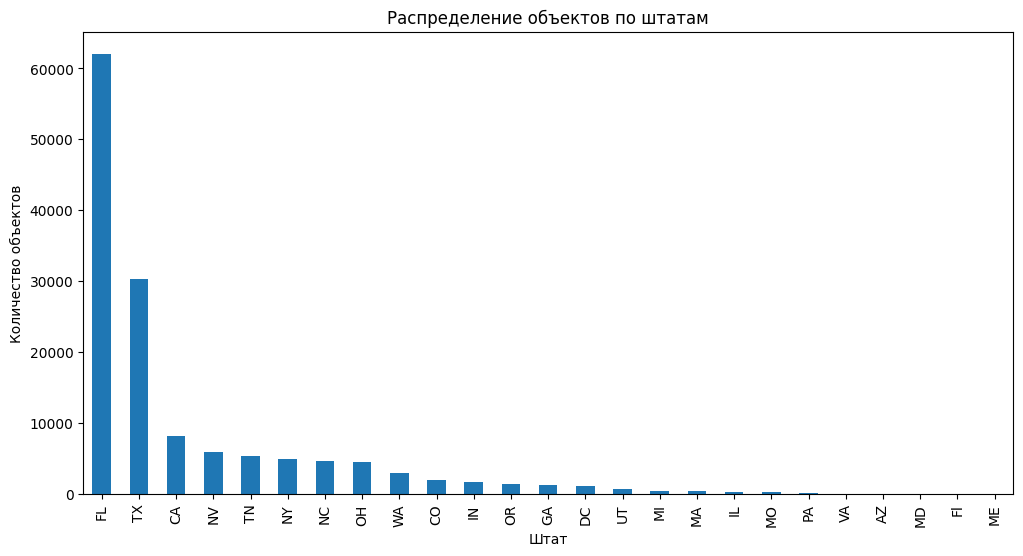

In [615]:
# Группировка по штатам и подсчет количества объектов
state_counts = df['state'].value_counts()

# Построение графика столбцов
plt.figure(figsize=(12, 6))
state_counts.plot(kind='bar')
plt.xlabel('Штат')
plt.ylabel('Количество объектов')
plt.title('Распределение объектов по штатам')
plt.show()
# львиная доля объектов находится во Флориде, Техасе и КАлифорнии

Столбец mls_id
Не очень уверена, что он влияет на цену объекта, предполагаю, что не влияет, но его можно без особых сложностей, на первый взгляд, обработать. 
сделаем это, а потом посмотрим на результат работы модели.

In [616]:
# создадим столбец мультилистинга , объединяющий оба столбца
df['mls_id']=df['mls-id'].fillna(df['MlsId'])
# сделаем бинарный признак int 
df['mls_id']=df['mls_id'].apply(lambda x: 1 if pd.notnull(x) else 0)
# удалим столбцы лишние 
df=df.drop(['mls-id','MlsId'],axis=1)


In [617]:
df['mls_id'].value_counts()

1    134447
0      3690
Name: mls_id, dtype: int64

In [618]:
null_values = df['mls_id'].isnull().sum()
zero_values = len(df[df['mls_id'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 0
Количество нулевых значений: 3690


столбец zipcode

In [619]:
# найдем пустые строки, которые не дают перевести столбец в int
null_values = df['zipcode'].value_counts(dropna=False).get('')
print(null_values)

None


In [620]:
# по коду выше нет пропущенных значениц, но выходит ошибка, поэтому блок try-except,
# чтобы обработать исключение `ValueError`, которое возникает при попытке преобразования пустой строки в целое число
df['zipcode'] = df['zipcode'].replace('', np.nan).str.split('-').str[0]
df['zipcode'] = df['zipcode'].fillna(0)
try:
    df['zipcode'] = df['zipcode'].astype(int)
except ValueError:
    df['zipcode'] = df['zipcode'].astype(str)

In [621]:
df['zipcode'] = df['zipcode'].replace('', '33305')
df['zipcode']=df['zipcode'].astype(int)

Столбец privatpool
у нас есть две пары столбцов с одной и той же информацией :
- наличие бассейна (столбцы private pool  и PrivatePoll)
- идентификатор MLS (Multiple Listing Service, система
мультилистинга (столбцы 'mls-id' и 'MlsId'))
Объединим их соответственно. 

In [622]:
# создадим столбец наличия бассейна, объединяющий оба столбца
df['privatepool'] = df['private pool'].fillna(df['PrivatePool']).apply(lambda x: 'Yes' if x in ['Yes', 'yes'] else x)
# сделаем бинарный признак int
df['privatepool'] = df['privatepool'].apply(lambda x: 1 if x == 'Yes' else 0)
# удалим столбцы 'private pool' и 'PrivatePool'
df = df.drop(['private pool', 'PrivatePool'], axis=1)
df['privatepool'].value_counts()

0    110553
1     27584
Name: privatepool, dtype: int64

столбуц stories

In [623]:
df['stories'].isnull().sum()*100/len(df)
# количество пустых значений 32 % и взять информацию для пополнения неоткуда. 
# информация крайне разрознена, хотя она очень важна для оценки стоимости жилья и 
# вообще для понимания объекта как такового. 
# удалим столбец
df=df.drop('stories',axis=1)

столбец fireplace

In [624]:
# очистим и сделаем бинарный признак
#  значения в столбце меняем на текстовый формат
df['fireplace'] = df['fireplace'].astype(str)
df['fireplace'] = df['fireplace'].str.lower()#  значения в нижний регистр 
df['fireplace'] = df['fireplace'].apply(lambda x: x.lower() if x is not None else None)
#  функция для проверки наличия ключевых слов
def check_keywords(text):
    keywords = ['yes', '1', 'fireplace', 'gas', '2', 'wood']
    for keyword in keywords:
        if keyword in text:
            return 1
    return 0
#  
df['fireplace'] = df['fireplace'].apply(check_keywords)

столбец beds
связан состолбцом baths

beds=beds_from_beds
baths_new=baths+baths_from_beds



In [625]:
# создадим два столбца beds_from_beds  baths_from_beds (тезнический для заполнения столбца baths)
# извлекаем уборные
df['beds'] = df['beds'].astype(str)
df['beds'] = df['beds'].str.lower()#  значения в нижний регистр 

def extract_beds(value):
    numbers = []
    words = value.split()
    for word in words:
        if word.isdigit():
            numbers.append(int(word))
    return numbers[0] if numbers else None
df['baths_from_beds'] = df.loc[df['beds'].str.contains('Baths|baths', na=False), 'beds'].apply(lambda x: extract_beds(x))


In [626]:
# извлекаем спальни
def extract_beds(value):
    numbers_bed = []
    words = value.split()
    for word in words:
        if word.isdigit():
            numbers_bed.append(int(word))
        elif word.lower() in ['beds', 'bd', 'badroom', 'badrooms']:
            for char in word:
                if char.isdigit():
                    numbers_bed.append(int(char))
    return numbers_bed[0] if numbers_bed else None
df['beds_from_beds'] = df['beds'].apply(lambda x: extract_beds(x) if 'baths' not in x else None)


In [627]:
null_values = df['beds_from_beds'].isnull().sum()
zero_values = len(df[df['beds_from_beds'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 34979
Количество нулевых значений: 405


In [628]:
df['beds_from_beds'].isnull().sum()*100/len(df) # пропущенные значения, доля %

25.321962978781933

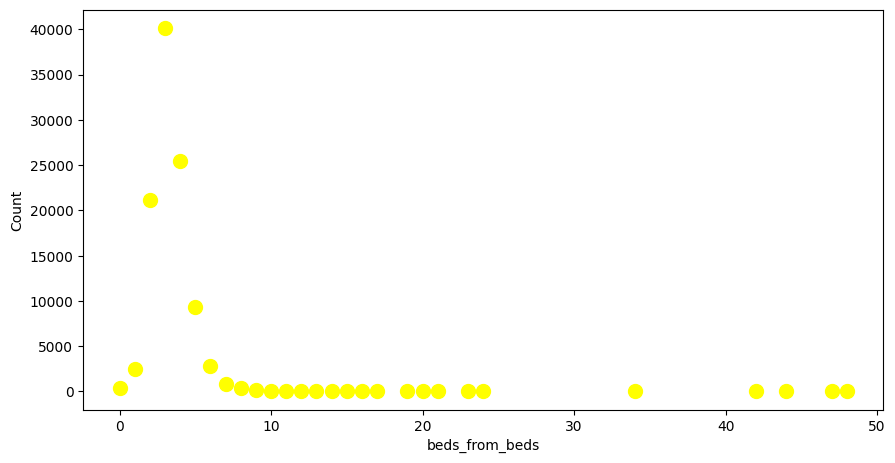

In [629]:
# визуализируем спальни 
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
counts = df['beds_from_beds'].value_counts()
x_values = counts.index
y_values = counts.values
axes.scatter( x=x_values, y=y_values, s=100, marker='o', c='yellow')
axes.set_xlabel('beds_from_beds')
axes.set_ylabel('Count')
plt.show()
# большое количество спален в домах

In [630]:
# допускаю, что может быть много спален  в домах с большой площадью, но пока будем действовать по классике
# Вычисление среднего и стандартного отклонения столбца 
# функция для метода z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
# применим функцию для нашего датафрэйма для столбца Year built
outliers, cleaned = outliers_z_score(df, 'beds_from_beds', log_scale=True)
df = cleaned
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 718
Результирующее число записей: 102440


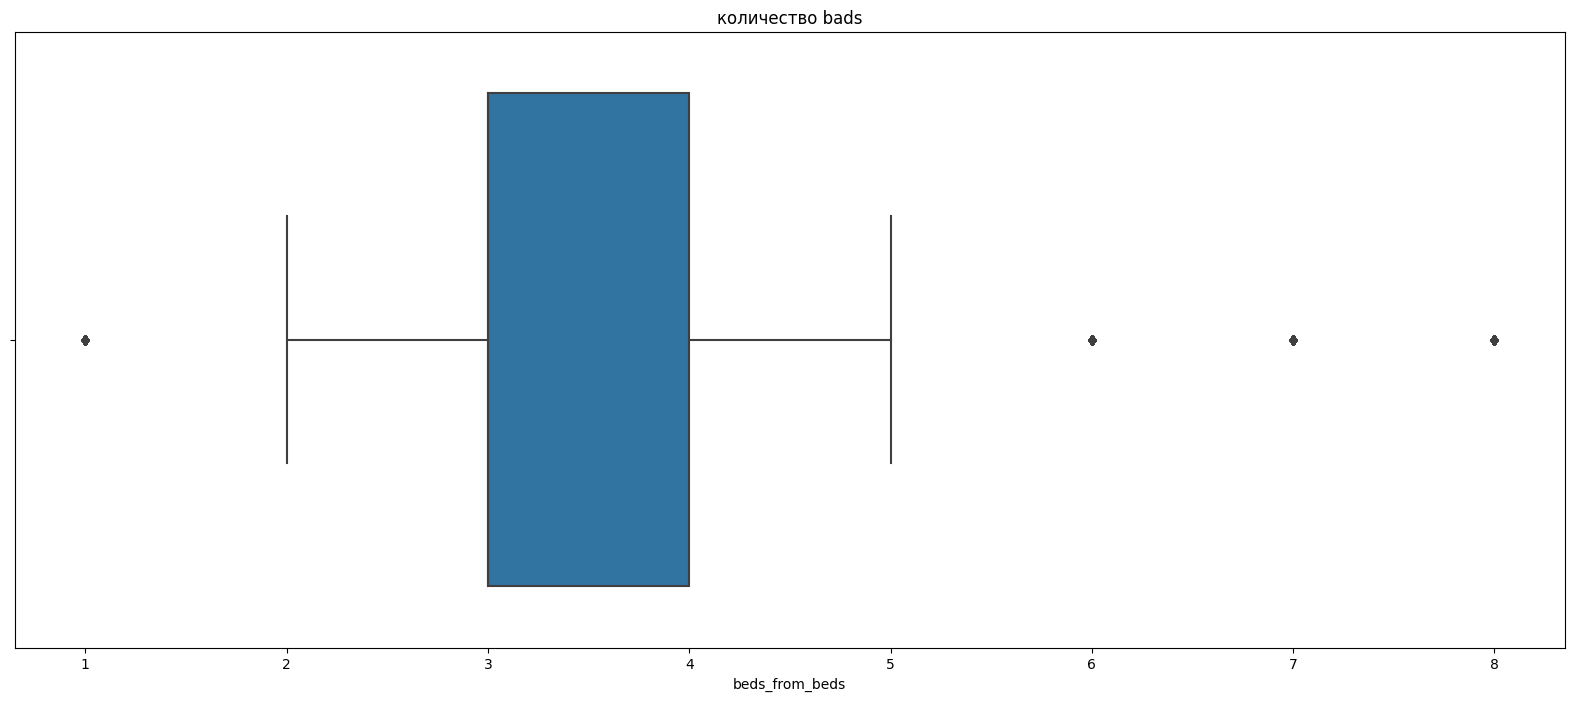

In [631]:
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='beds_from_beds', ax=axes[1])
boxplot.set_title('количество bads')
plt.show()

оставим эти выбросы, т.к. бывают объекты с 1 и 8 уборными

In [632]:
null_values = df['beds_from_beds'].isnull().sum()
zero_values = len(df[df['beds_from_beds'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 0
Количество нулевых значений: 0


In [633]:
df['beds_from_beds'].value_counts()

3.0    40170
4.0    25472
2.0    21108
5.0     9284
6.0     2798
1.0     2443
7.0      770
8.0      395
Name: beds_from_beds, dtype: int64

столбец baths

In [634]:
# очистим данные в столбце уборные 
df['baths'] = df['baths'].astype(str)
df['baths'] = df['baths'].str.lower()#  значения в нижний регистр 

def extract_baths(value):
    numbers = []
    words = value.split()
    for word in words:
        if word.isdigit():
            numbers.append(int(word))
    return numbers[0] if numbers else None
df['baths_new'] = df.loc[df['baths'].str.contains('bathrooms|baths|ba', na=False), 'baths'].apply(lambda x: extract_baths(x))

In [635]:
df['baths_new'].isnull().sum()
#  пропусков, много, но есть резерв - данные из столбца bads: df['baths_from_beds]

36783

In [636]:
df['baths_new'] = df['baths_new'].fillna(df['baths_from_beds'])# замена нулевых значений их технического столбца 
# замена ничего не дала расстанемся со столбцом

In [637]:
null_values = df['baths_new'].isnull().sum()
zero_values = len(df[df['baths_new'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 36783
Количество нулевых значений: 0


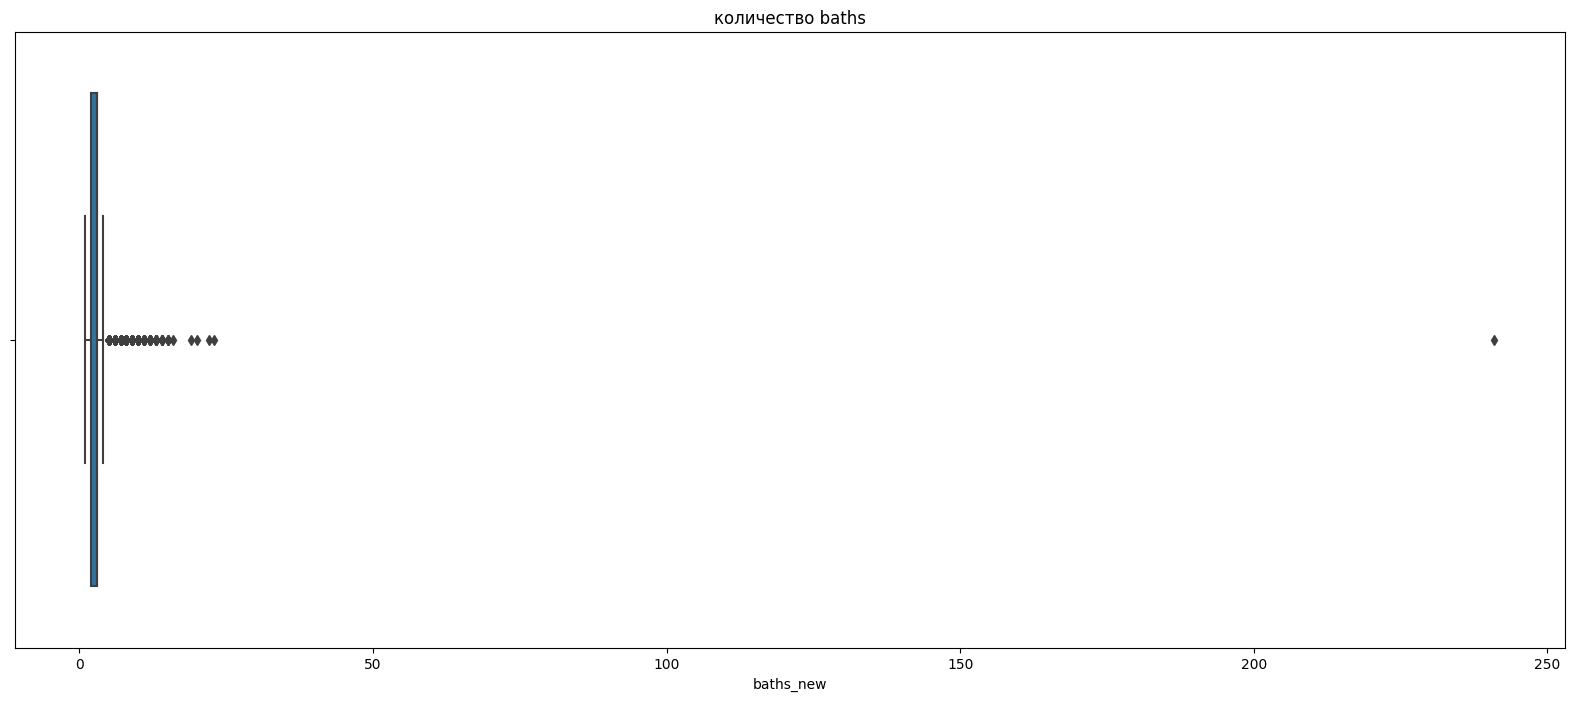

In [638]:
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='baths_new', ax=axes[1])
boxplot.set_title('количество baths')
plt.show()

In [639]:
# строка с 241 ванной= выброс
baths_max=df.loc[df['baths_new']==241]
print(baths_max)

         status   propertyType             street           baths  fireplace  \
11118  For sale  Single Family  1204 E Helena Ave  bathrooms: 241          0   

          city                                            schools  \
11118  McAllen  [{'rating': ['6/10', 'NA', '4/10'], 'data': {'...   

                                          sqft  zipcode  beds  ... Heating  \
11118  Total interior livable area: 3,770 sqft    78503  4 bd  ...       1   

      Cooling        Lot size  Parking Category  Price_sgu_clean  mls_id  \
11118       1  0.37 acres lot            Garage            119.0       0   

       privatepool baths_from_beds beds_from_beds  baths_new  
11118            0             NaN            4.0      241.0  

[1 rows x 25 columns]


In [640]:
index_to_drop = df.loc[df['baths_new'] == 241].index   # удалим выброс
df = df.drop(index_to_drop)

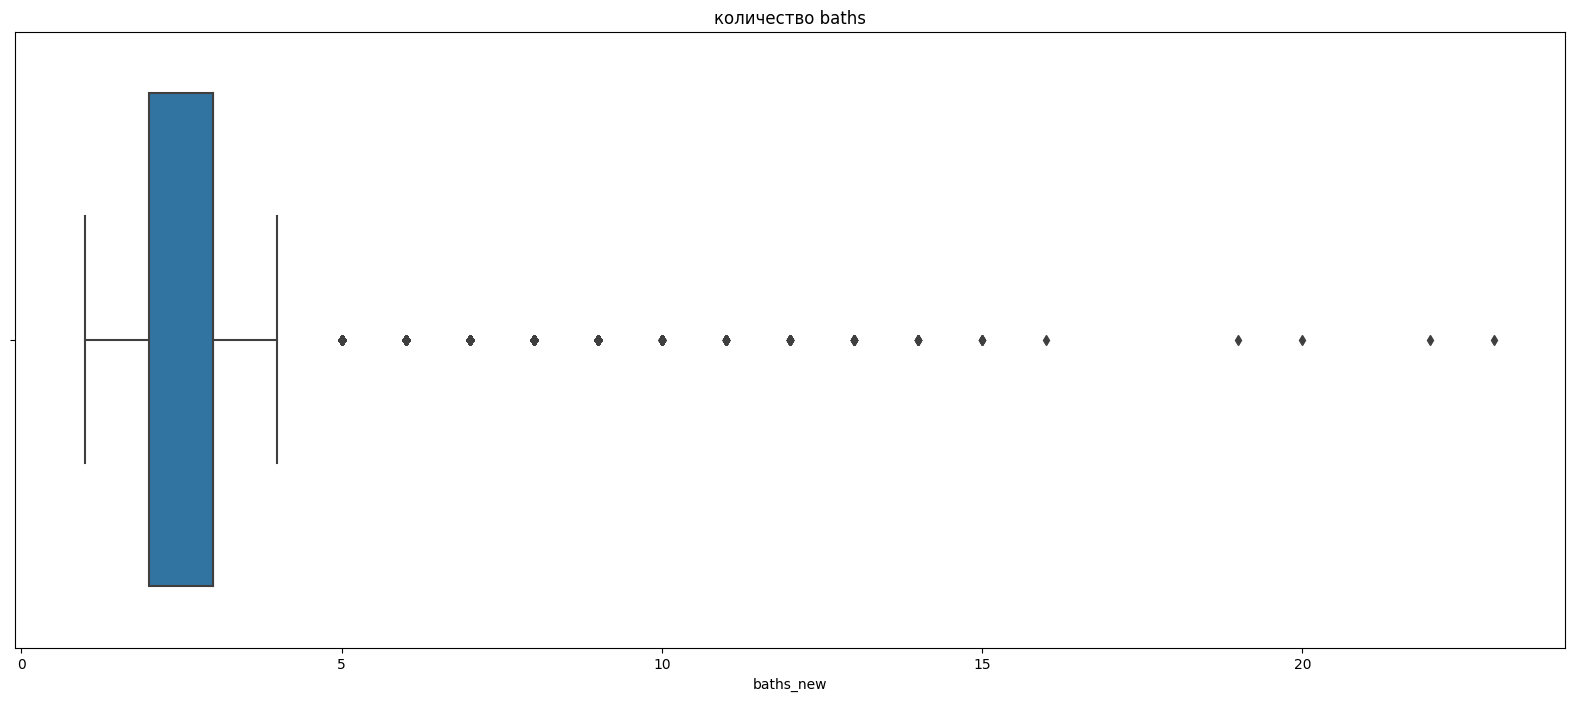

In [641]:
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='baths_new', ax=axes[1])
boxplot.set_title('количество baths')
plt.show()

In [642]:
# Все, что больше 4 ванн выглядит как выброс, 

Число выбросов по методу z-отклонения: 797
Результирующее число записей: 64859


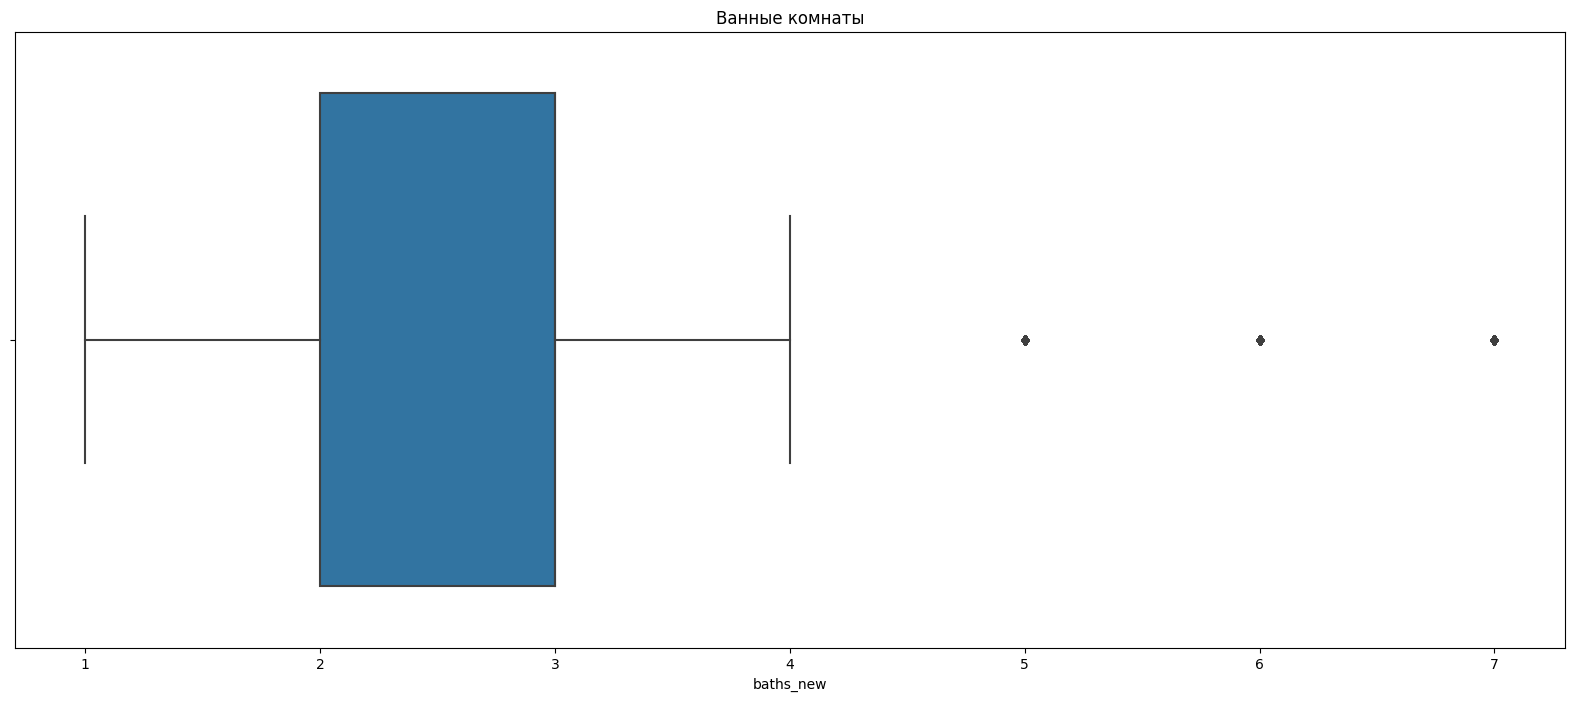

In [643]:
# функция для метода z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log1p(data[feature])
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
# применим функцию для нашего датафрэйма для столбца 
outliers, cleaned = outliers_z_score(df, 'baths_new', log_scale=True)
df = cleaned
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='baths_new', ax=axes[1])
boxplot.set_title('Ванные комнаты')
plt.show()


Число выбросов по методу IQR: 749
Результирующее число записей: 62596


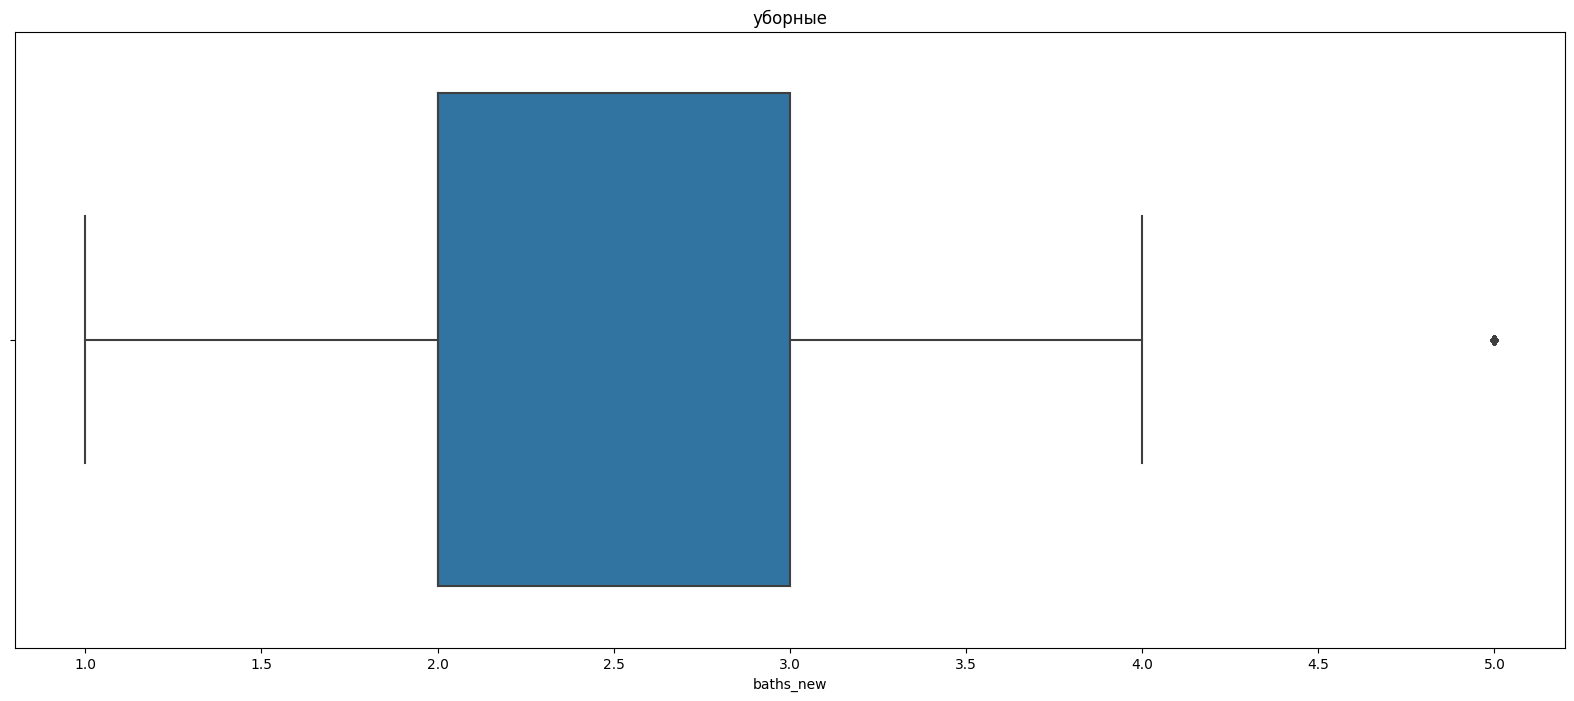

In [644]:
# удалим выбросы справа от усов
Q1 = df['baths_new'].quantile(0.25)
Q3 = df['baths_new'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers = df[(df['baths_new'] < lower_bound) | (df['baths_new'] > upper_bound)]
cleaned = df[df['baths_new'] < upper_bound]
df = cleaned

print(f'Число выбросов по методу IQR: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
# смотрим выбросы sqft
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='baths_new', ax=axes[1])

boxplot.set_title('уборные')
plt.show()

In [645]:
# заполним пропуски 
mean_value = df['baths_new'].mean()
df['baths_new'] = df['baths_new'].fillna(mean_value)

In [646]:
df['baths_new']=pd.to_numeric(df['baths_new'], errors='coerce') # переведем в числовой формат  и переименуем


In [647]:
null_values = df['baths_new'].isnull().sum()
zero_values = len(df[df['baths_new'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 0
Количество нулевых значений: 0


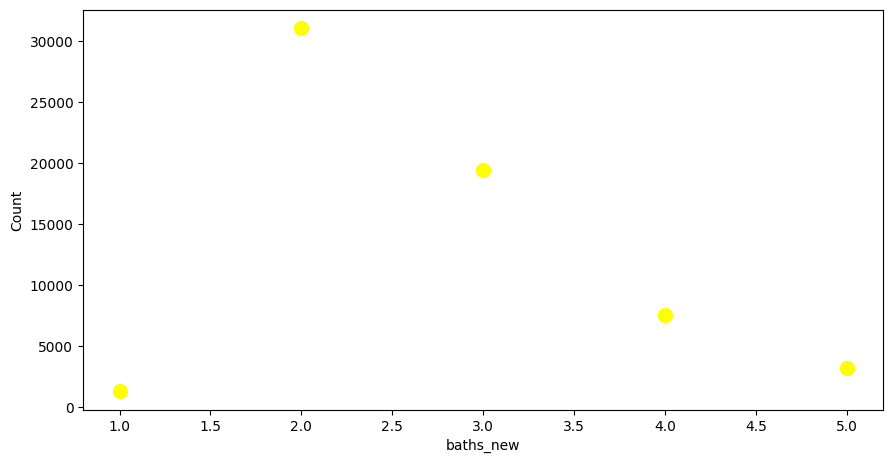

In [648]:
# визуализируем 
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
counts = df['baths_new'].value_counts()
x_values = counts.index
y_values = counts.values
axes.scatter( x=x_values, y=y_values, s=100, marker='o', c='yellow')
axes.set_xlabel('baths_new')
axes.set_ylabel('Count')
plt.show()

Cтолбец sqft и столбец target

In [649]:
# очистим столбец площадь и переведем в тип int
df['sqft'] = df['sqft'].str.replace(',', '').str.replace('.', '').str.replace('sqft', '').str.replace('Total interior livable area:', '').str.strip()
df['sqft'] = pd.to_numeric(df['sqft'], errors='coerce')



C:\Users\1\AppData\Local\Temp\ipykernel_22596\166106814.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['sqft'] = df['sqft'].str.replace(',', '').str.replace('.', '').str.replace('sqft', '').str.replace('Total interior livable area:', '').str.strip()


In [650]:
null_values = df['sqft'].isnull().sum()
zero_values = len(df[df['sqft'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 0
Количество нулевых значений: 0


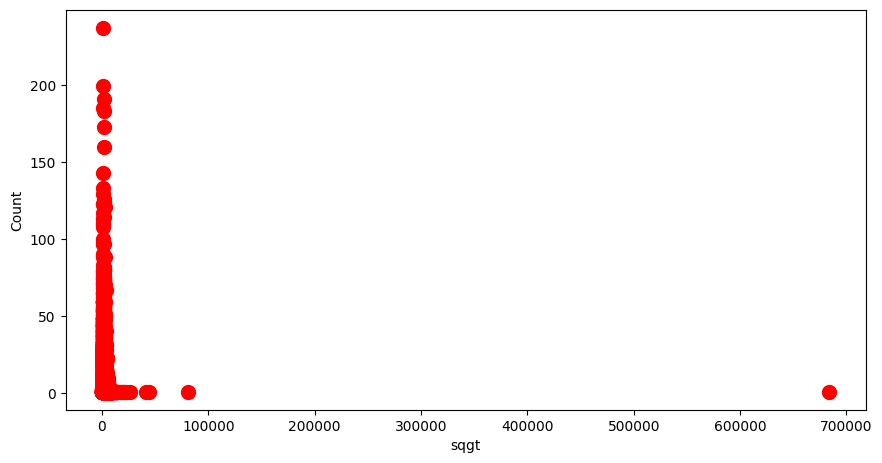

In [651]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
counts = df['sqft'].value_counts()
x_values = counts.index
y_values = counts.values
axes.scatter( x=x_values, y=y_values, s=100, marker='o', c='red')
axes.set_xlabel('sqgt')
axes.set_ylabel('Count')
plt.show()

In [652]:
# столбец target
# убираем лишние знаки df['target'] = df['target'].replace(['$', ',', '+', '/mo'], '', regex=False).str.split('-').str.get(0)
df['target'] = df['target'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).str.replace('+', '', regex=False).str.replace('/mo','',regex=False).str.split('-').str.get(0)
df['target']=pd.to_numeric(df['target']) # переводим в числовлй формат

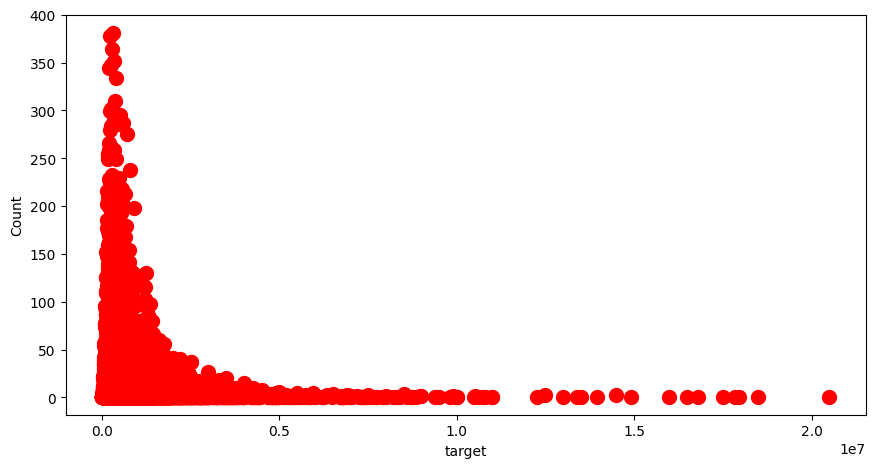

In [653]:
# визуализируем targets
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
counts = df['target'].value_counts()
x_values = counts.index
y_values = counts.values
axes.scatter( x=x_values, y=y_values, s=100, marker='o', c='red')
axes.set_xlabel('target')
axes.set_ylabel('Count')
plt.show()


In [654]:
# для targets
null_values_t = df['target'].isnull().sum()
zero_values_t = len(df[df['target'] == 0])
print(f"Количество пропущенных значений targets:  {null_values_t}")
print(f"Количество нулевых значений targets : {zero_values_t}")

Количество пропущенных значений targets:  111
Количество нулевых значений targets : 0


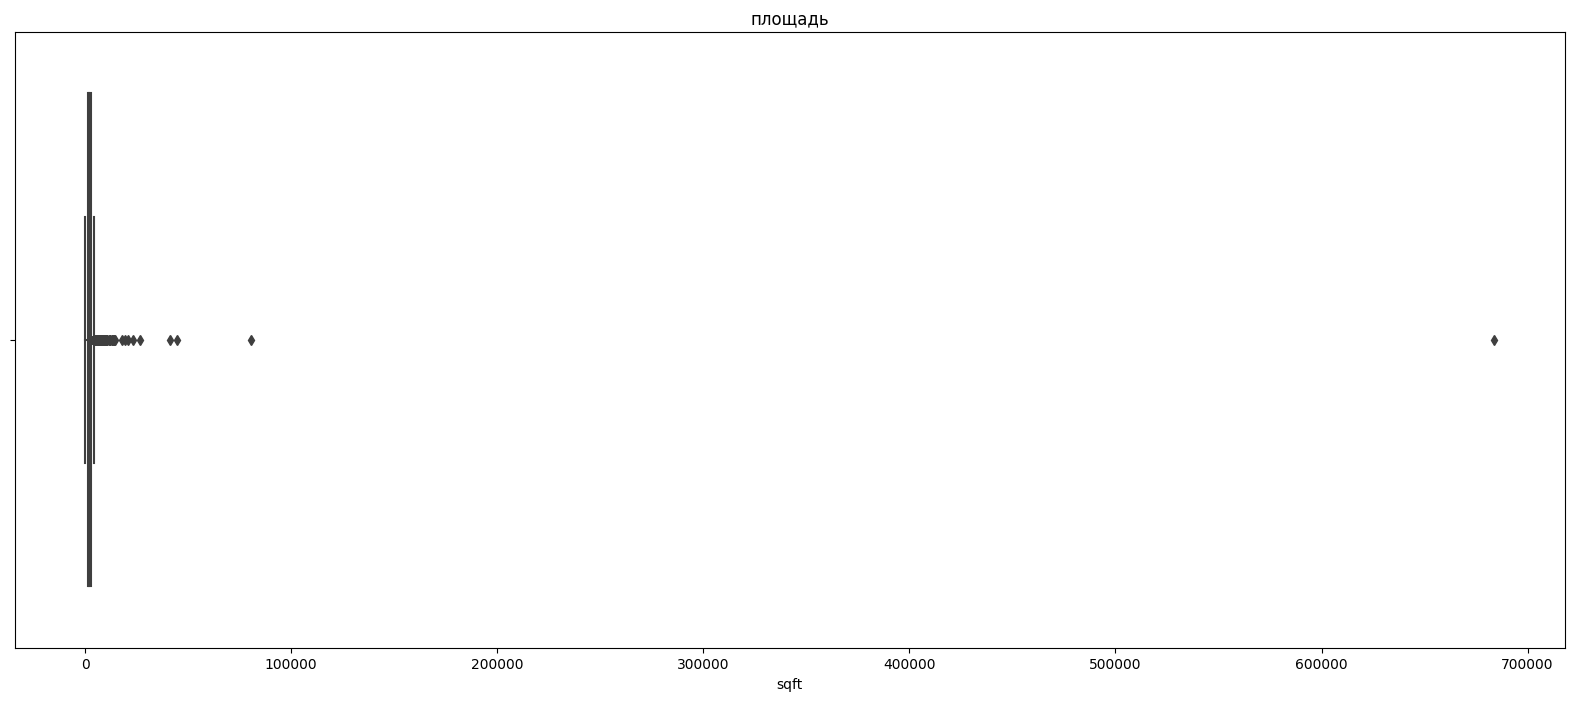

In [655]:
# смотрим выбросы sqft
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='sqft', ax=axes[1])
boxplot.set_title('площадь')
plt.show()

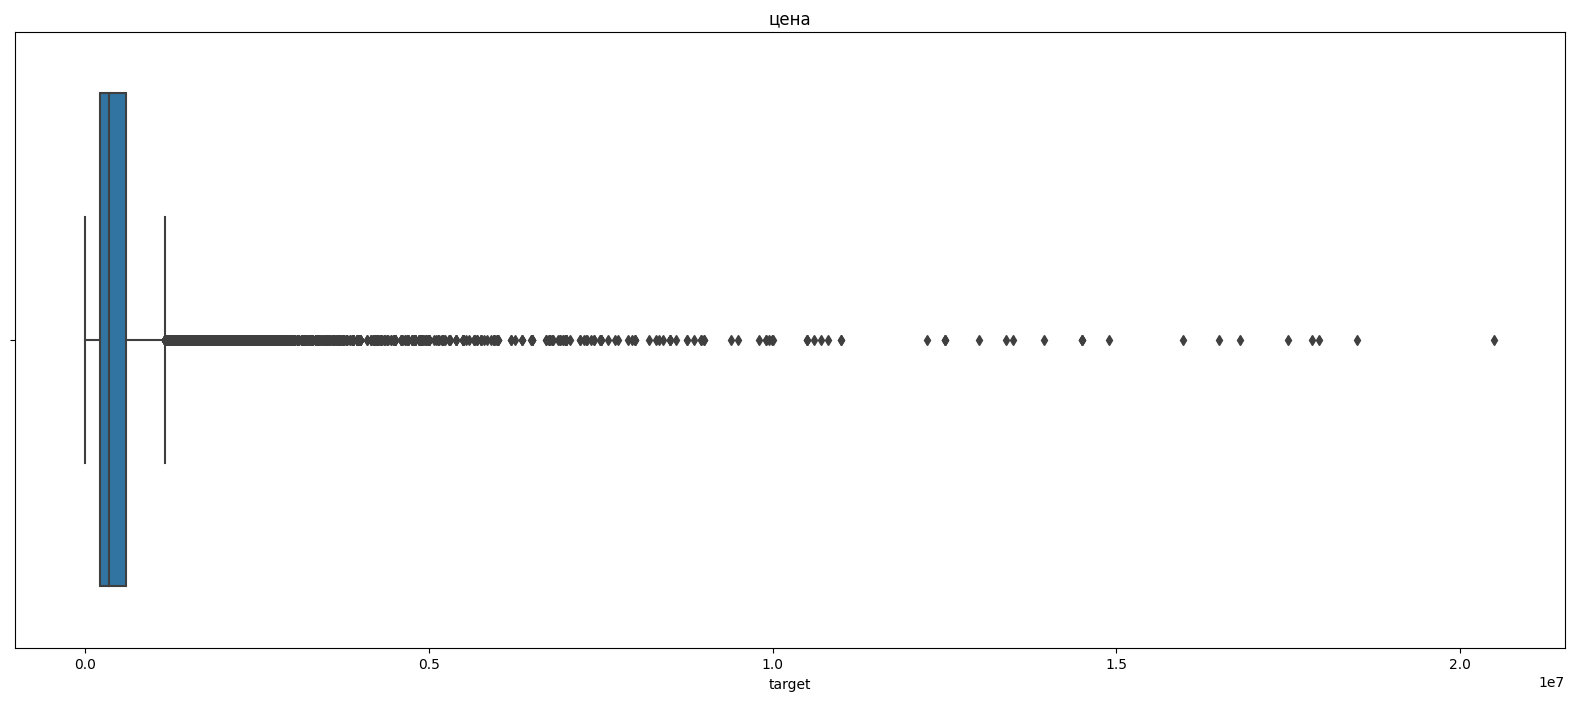

In [656]:
# смотрим выбросы target
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='target', ax=axes[1])
boxplot.set_title('цена')
plt.show()

In [657]:
# Вывод 15 максимальных значений столбца 'sqft'
top_15_sqft = df.nlargest(15, 'sqft')
print("Максимальные 15 значений для столбца 'sqft':")
print(top_15_sqft[['sqft', 'target']])

Максимальные 15 значений для столбца 'sqft':
          sqft      target
82974   683892    199000.0
79117    80652   3000000.0
291641   44431    640000.0
317106   40989    799000.0
157504   26500   1295000.0
200762   23000    728000.0
124352   20900   2797000.0
182693   19565   2200000.0
66097    17800    487500.0
143908   14500  12250000.0
374970   13837   2695000.0
203506   13794   2600000.0
92730    13492    615000.0
298582   13215    395000.0
212821   12880    390000.0


In [658]:
# замена выброса в sqft
#target_mean = df['target'].mean()
#sqft_mean = df['sqft'].mean()
#value_to_replace = df.loc[62736, 'target'] / (target_mean / sqft_mean)
#df.loc[62736, 'sqft'] = value_to_replace

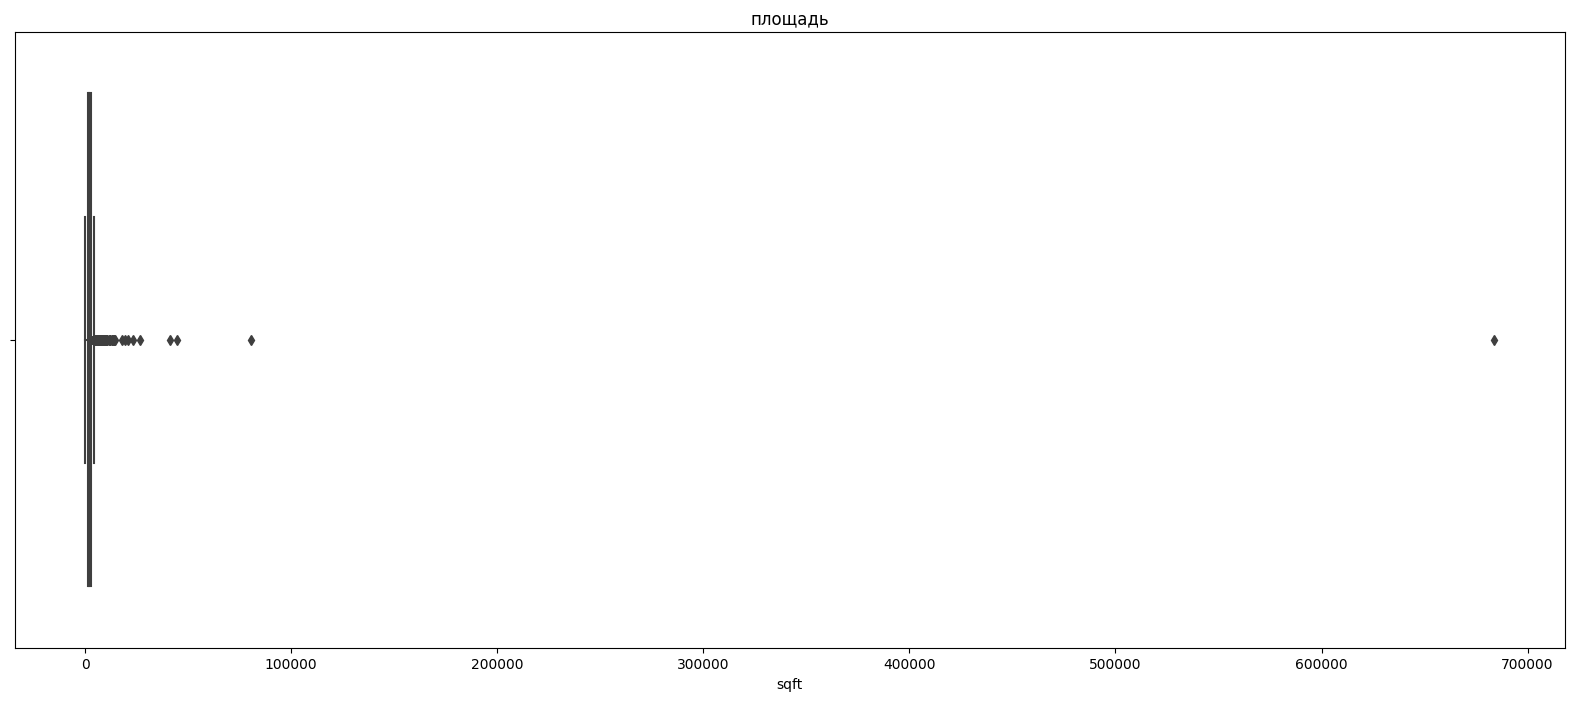

In [659]:
# смотрим выбросы sqft
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='sqft', ax=axes[1])
boxplot.set_title('площадь')
plt.show()

In [660]:
Q1 = df['sqft'].quantile(0.25)
Q3 = df['sqft'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3* IQR

outliers = df[(df['sqft'] < lower_bound) | (df['sqft'] > upper_bound)]
cleaned = df[(df['sqft'] >= lower_bound) & (df['sqft'] <= upper_bound)]
df=cleaned
print(f'Число выбросов по методу IQR: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу IQR: 262
Результирующее число записей: 62334


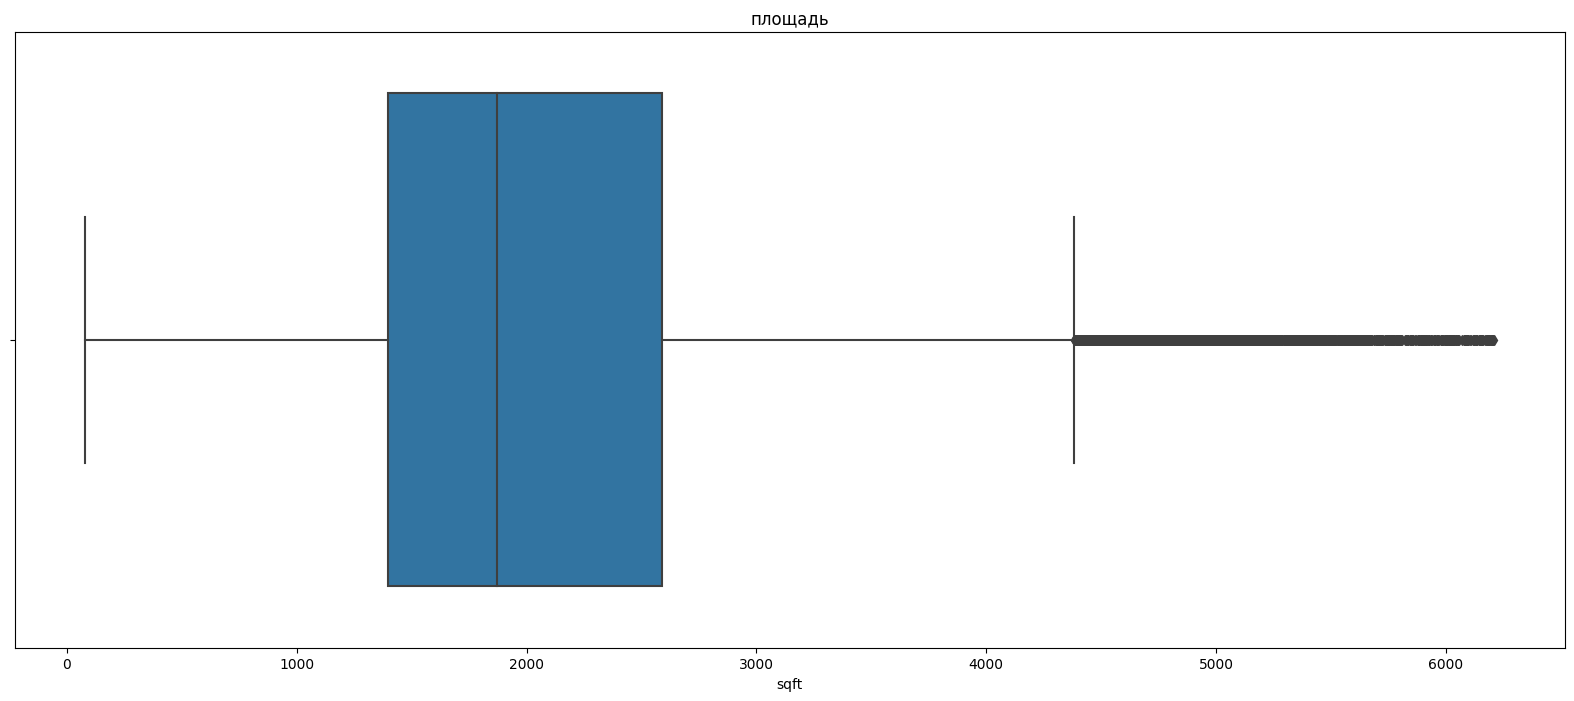

In [661]:
# смотрим выбросы sqft
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='sqft', ax=axes[1])
boxplot.set_title('площадь')
plt.show()

Число выбросов по методу IQR: 18
Результирующее число записей: 62316


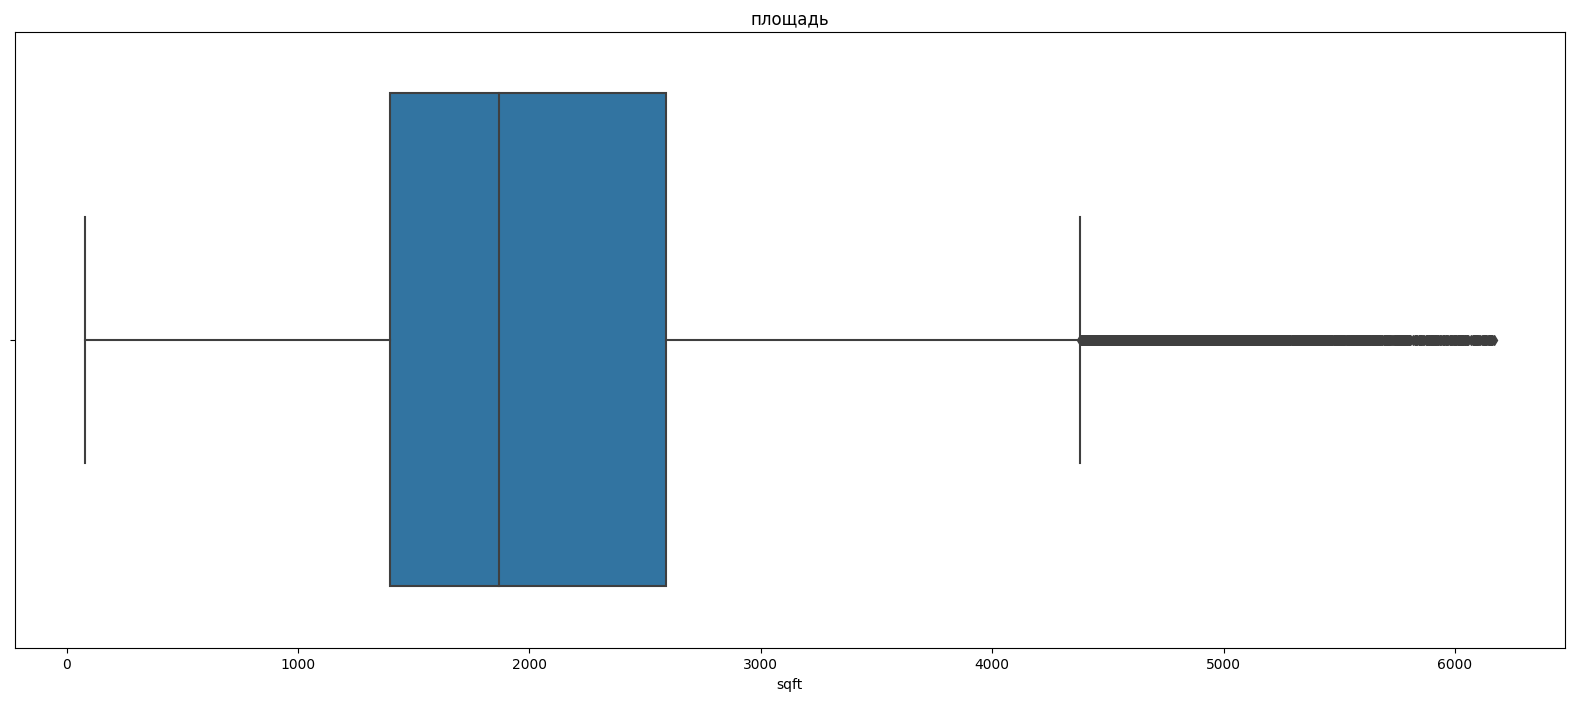

In [662]:
# удалим выбросы справа от усов
Q1 = df['sqft'].quantile(0.25)
Q3 = df['sqft'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers = df[(df['sqft'] < lower_bound) | (df['sqft'] > upper_bound)]
cleaned = df[df['sqft'] < upper_bound]
df = cleaned

print(f'Число выбросов по методу IQR: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
# смотрим выбросы sqft
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='sqft', ax=axes[1])
boxplot.set_title('площадь')
plt.show()

In [663]:
df['sqft']=df['sqft'].fillna(df['sqft'].median())

In [664]:
df=df[df['sqft']<=4500]

In [665]:
null_values = df['sqft'].isnull().sum()
zero_values = len(df[df['sqft'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 0
Количество нулевых значений: 0


In [666]:
# Вывод 15 максимальных значений столбца 'target'
top_15_target = df.nlargest(15, 'target')
print("Максимальные 15 значений для столбца 'target':")
print(top_15_target[['sqft', 'target']])


Максимальные 15 значений для столбца 'target':
        sqft      target
67907   2231  17500000.0
25491   4250  16800000.0
20349   3867  14900000.0
122976  2721  14500000.0
155840  3537  14500000.0
295132  3164  14500000.0
88170   4500  13500000.0
208249  2900  12500000.0
110285  3849  10995000.0
102384  2735  10990000.0
168141  4450  10700000.0
311963  4500  10500000.0
269522  3584   9999999.0
337646  3700   9995000.0
20716   3602   8995000.0


In [667]:
null_values = df['target'].isnull().sum()
zero_values = len(df[df['target'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 107
Количество нулевых значений: 0


In [668]:
Q1 = df['target'].quantile(0.25)
Q3 = df['target'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3* IQR

outliers = df[(df['target'] < lower_bound) | (df['target'] > upper_bound)]
cleaned = df[(df['target'] >= lower_bound) & (df['target'] <= upper_bound)]
df=cleaned
print(f'Число выбросов по методу IQR: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')


Число выбросов по методу IQR: 2036
Результирующее число записей: 58271


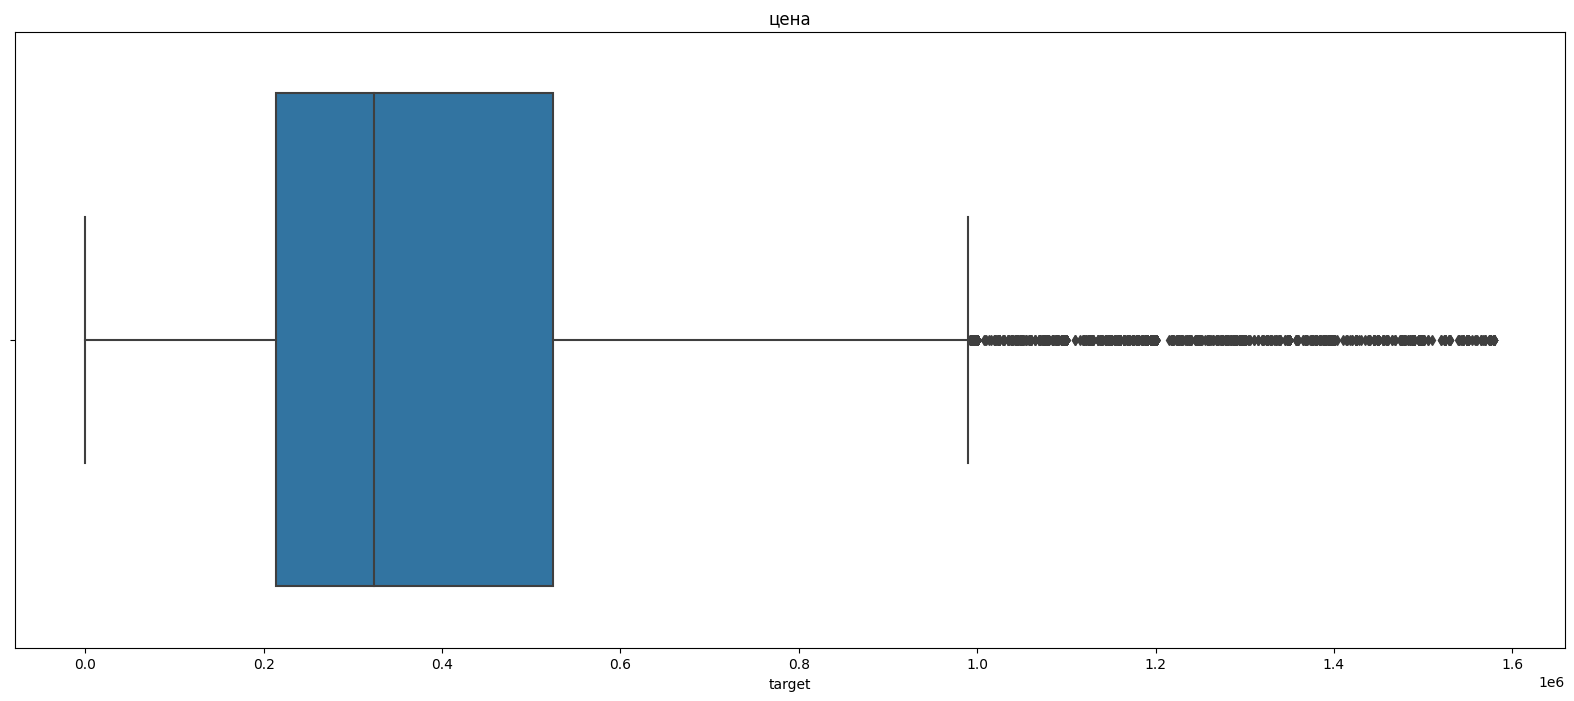

In [669]:
# смотрим выбросы target
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='target', ax=axes[1])
boxplot.set_title('цена')
plt.show()

Число выбросов по методу IQR: 378
Результирующее число записей: 57893


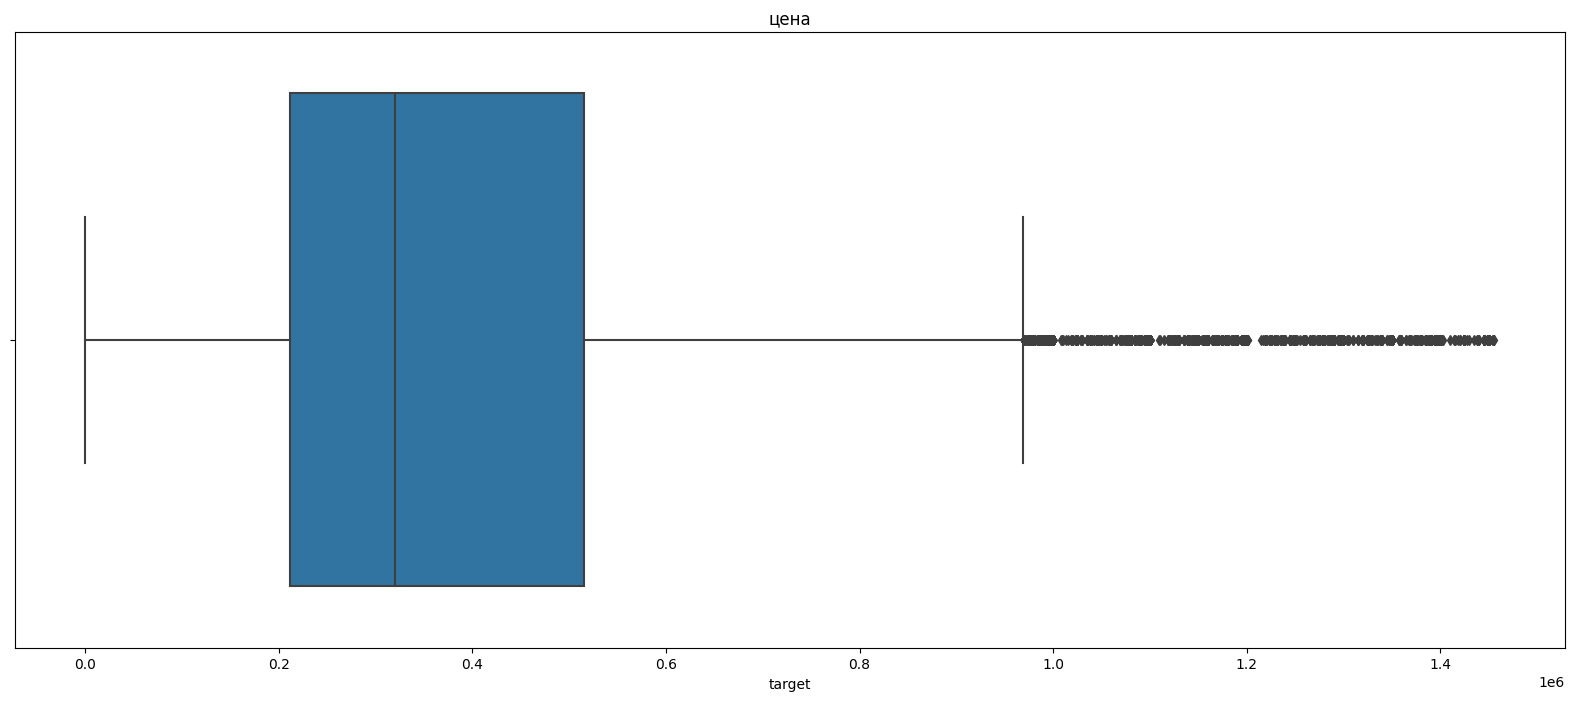

In [670]:
# удалим выбросы справа от усов
Q1 = df['target'].quantile(0.25)
Q3 = df['target'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers = df[(df['target'] < lower_bound) | (df['target'] > upper_bound)]
cleaned = df[df['target'] < upper_bound]
df = cleaned

print(f'Число выбросов по методу IQR: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
# смотрим выбросы sqft
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='target', ax=axes[1])
boxplot.set_title('цена')
plt.show()

In [671]:
df['target'].mean()

402796.571105315

In [672]:
right_whisker_data = cleaned[cleaned['target'] > upper_bound]
print(len(right_whisker_data))

0


In [673]:
# замена пропусков target 
df['target']=df['target'].fillna(df['target'].median())

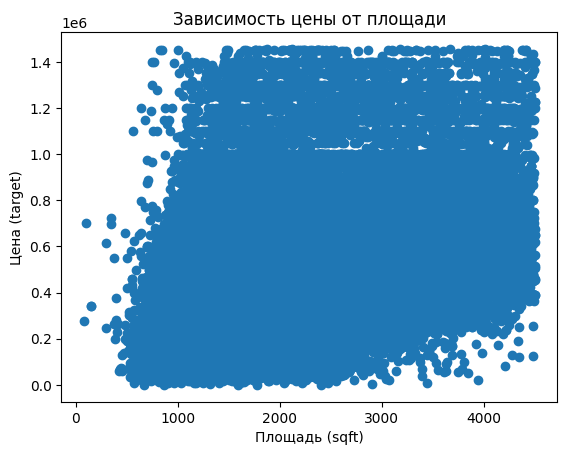

In [674]:
plt.scatter(df['sqft'], df['target'])
plt.xlabel('Площадь (sqft)')
plt.ylabel('Цена (target)')
plt.title('Зависимость цены от площади')
plt.show()

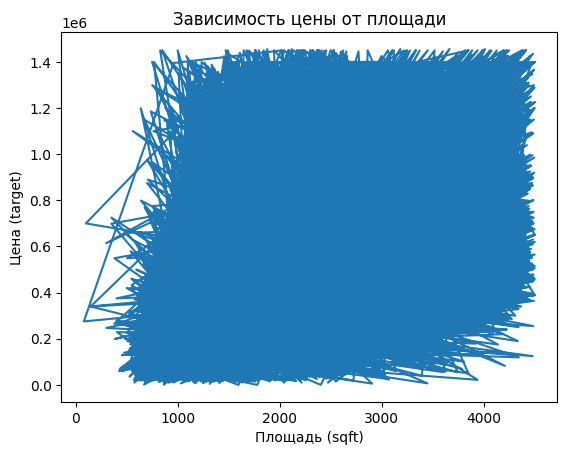

In [675]:
# Построение линейного графика
plt.plot(df['sqft'], df['target'])
plt.xlabel('Площадь (sqft)')
plt.ylabel('Цена (target)')
plt.title('Зависимость цены от площади')
plt.show()

In [676]:
null_values = df['target'].isnull().sum()
zero_values = len(df[df['target'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 0
Количество нулевых значений: 0


Столбец schools

In [677]:
# Десериализация  столбца 'school'
import ast
import json
# json.dumps()  список x в строку JSON, 
#  json.loads()  строку JSON обратно в список

df['schools'] = df['schools'].apply(lambda x: ast.literal_eval(x))

In [678]:
# Новые признаки

df['rating_count'] = df['schools'].apply(lambda x: len(x[0]['rating']))
# проверка if r перед  int() : сторока r != None перед преобразованием  в int.
# проверка and '/' in r : "/" есть в строке r( ошибка преобразования None в int, если нет "/")( ошибка "invalid literal for int() with base 10: 'None')
# проверка r.split('/')[0].isdigit() является ли первая часть разделенной строки r числом (ошибка преобразования None в int)
df['average_rating'] = df['schools'].apply(lambda x: np.mean([int(r[0].split('/')[0]) for r in x[0]['rating'] if r and r[0] != 'NR' and r[0].split('/')[0].isdigit()]))

# any() проверка, что есть хотя бы один непустой элемент в последовательности
# x[0]['data']['Distance']` перед вызовом функции min() (ошибка min() arg is an empty sequence)
# двойная проверка `if d and d.split(' ')[0][:-2] : строка d и результат послек среза и раздела не пустые( ошибка could not convert string to float)

df['closest_distance'] = df['schools'].apply(lambda x: min(float(d.split(' ')[0][:-2]) for d in x[0]['data']['Distance'] if d and d.split(' ')[0][:-2]) if x and x[0]['data']['Distance'] and any(d for d in x[0]['data']['Distance'] if d and d.split(' ')[0][:-2]) else 0)

# Очистка и преобразование  в столбце Grades
# проверка if g is not None:  пропустить None  и не вызывать split()

df['Grades'] = df['schools'].apply(lambda x: [g.split('-')[-1] for g in x[0]['data']['Grades'] if g is not None])

# заполняем пропуски в столбце average_rating средним
mean_rating = np.mean([int(r[0].split('/')[0]) for r in df['schools'].apply(lambda x: x[0]['rating'] if x[0]['rating'] else []) if r and r[0] != 'NR' and r[0].split('/')[0].isdigit()])
df['average_rating'] = df['average_rating'].fillna(mean_rating)

c:\Users\1\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [679]:
df[['rating_count','average_rating','closest_distance','Grades']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57893 entries, 12 to 377182
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating_count      57893 non-null  int64  
 1   average_rating    57893 non-null  float64
 2   closest_distance  57893 non-null  float64
 3   Grades            57893 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 2.2+ MB


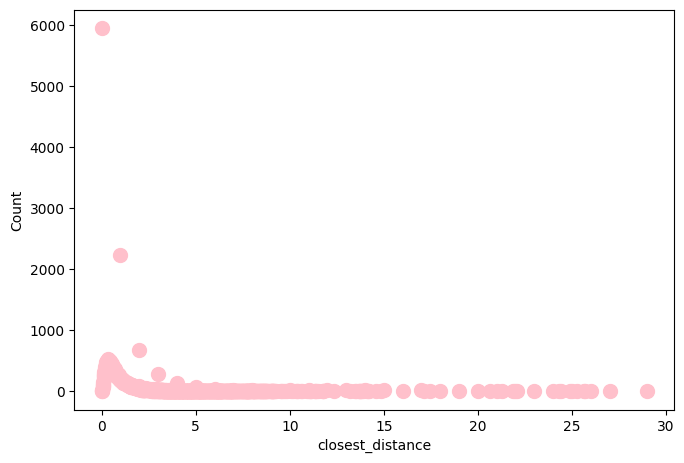

In [680]:
# визуализируем closest_distance
fig = plt.figure(figsize=(6, 4))
axes = fig.add_axes([0, 0, 1, 1])
counts = df['closest_distance'].value_counts()
x_values = counts.index
y_values = counts.values
axes.scatter( x=x_values, y=y_values, s=100, marker='o', c='pink')
axes.set_xlabel('closest_distance')
axes.set_ylabel('Count')
plt.show()
# максимум 1600 миль - это много 

In [681]:
# максимум 1590 миль, это много, похоже на выброс
# 40 миль это может быть в пределах города, посмотрим сколько таких значений 
err_dist=df[df['closest_distance']>=40]
print(err_dist)


Empty DataFrame
Columns: [status, propertyType, street, baths, fireplace, city, schools, sqft, zipcode, beds, state, target, street_category, Year built, Remodeled year, Heating, Cooling, Lot size, Parking Category, Price_sgu_clean, mls_id, privatepool, baths_from_beds, beds_from_beds, baths_new, rating_count, average_rating, closest_distance, Grades]
Index: []

[0 rows x 29 columns]


In [682]:
# группируем по городу и расстоянию до школы
grouped_data = df.groupby(['city', 'closest_distance'])

# данные для городов из выборки выше
selected_cities = ['Sylmar'] 
# также перебрала города: 
# Falcon Heights(max=312), El Paso (max=40.3), Dell City(max=45.13), Sylmar(max=40.65), 
# Santa Ana(max=356815),Maiami Beach(max=1187.14), Needmore(max=775.19)
selected_data = grouped_data.apply(lambda x: x[x['city'].isin(selected_cities)])

# Вывести выбранные данные
print(selected_data)

                                     status        propertyType  \
city   closest_distance                                           
Sylmar 0.11             223033  foreclosure  single-family home   
       0.17             303061     for sale               condo   
       0.22             66344   foreclosure  single-family home   
                        233235     for sale  single-family home   
       0.23             298409     for sale  single-family home   
       0.24             338041     for sale  single-family home   
       0.26             57772      for sale           townhouse   
       0.28             136107     for sale  single-family home   
                        293890     for sale           townhouse   
       0.32             202684     for sale           townhouse   
       0.33             66233      for sale           townhouse   
       0.36             149424     for sale  single-family home   
                        242607     for sale  single-family hom

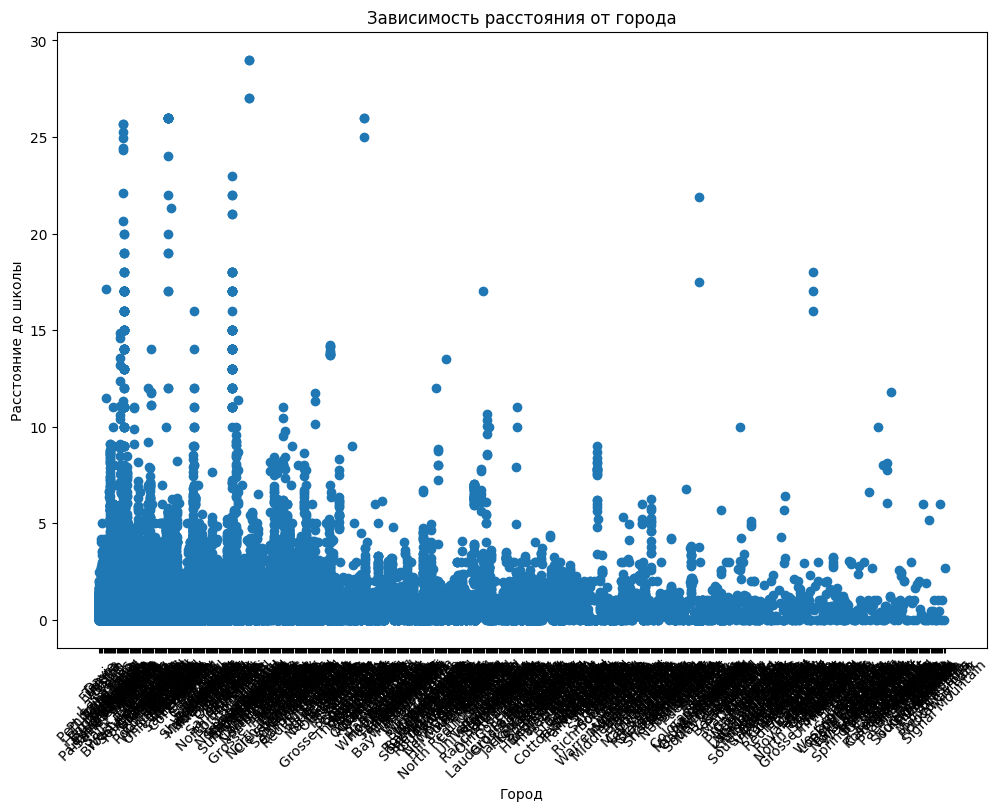

In [683]:
# Визуализация зависимости расстояния от города
plt.figure(figsize=(12, 8))
plt.scatter(df['city'], df['closest_distance'])
plt.xlabel('Город')
plt.ylabel('Расстояние до школы')
plt.title('Зависимость расстояния от города')
plt.xticks(rotation=45)
plt.show()

In [684]:
#  есть явные выбросы 
# Удаляем выбросы по условию
df.loc[df['closest_distance'] > 20, 'closest_distance'] = df.groupby('city')['closest_distance'].transform('min')

# Заполняем нулевые значения
df['closest_distance'] = df.groupby('city')['closest_distance'].transform(lambda x: x.replace(0, np.mean(x)))

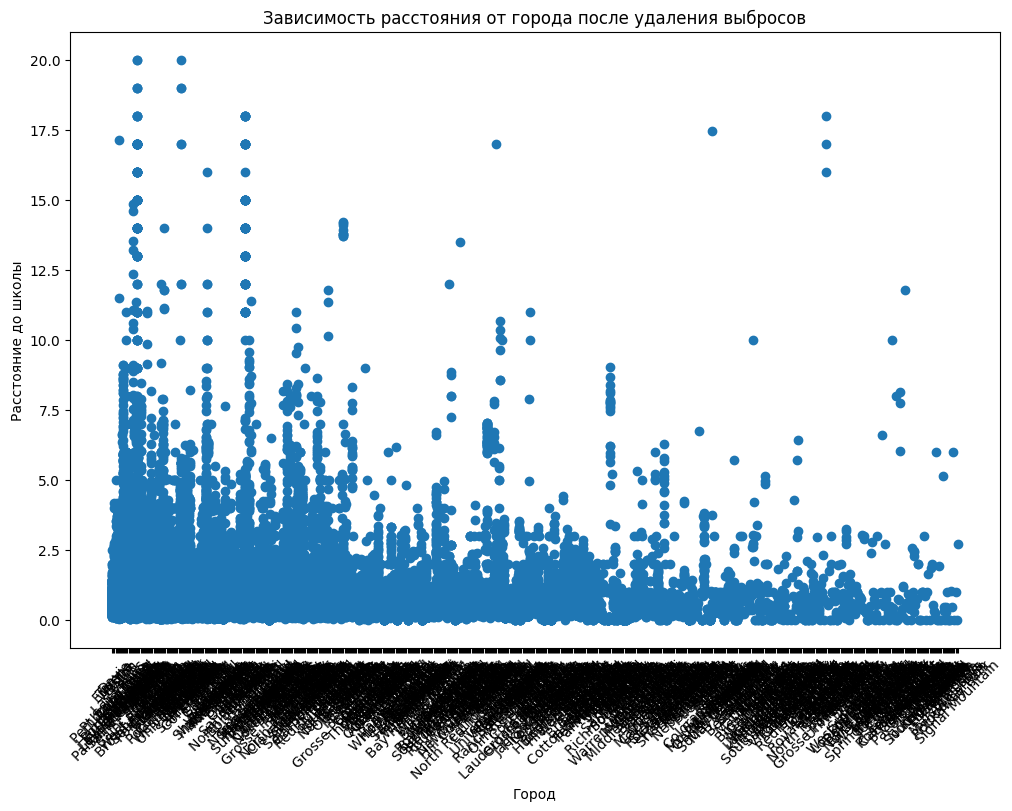

In [685]:
# Визуализация зависимости расстояния от города после удаления выбросов
plt.figure(figsize=(12, 8))
plt.scatter(df['city'], df['closest_distance'])
plt.xlabel('Город')
plt.ylabel('Расстояние до школы')
plt.title('Зависимость расстояния от города после удаления выбросов')
plt.xticks(rotation=45)
plt.show()
# осталось значение более 300 миль - это город Falcon Heights

In [686]:
# Фолкон-Хайтс — город в округе Рамси, штат Миннесота, США. На площади 5,8 км², согласно переписи 2002 года, проживают 5572 человека. 
# Плотность населения составляет 960,6 чел./км²
# удалим выбросы, т.к. школы в этом городе явно ближе чем 312 
df = df[df['closest_distance'] <= 30]

In [687]:
null_values = df['closest_distance'].isnull().sum()
zero_values = len(df[df['closest_distance'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 0
Количество нулевых значений: 323


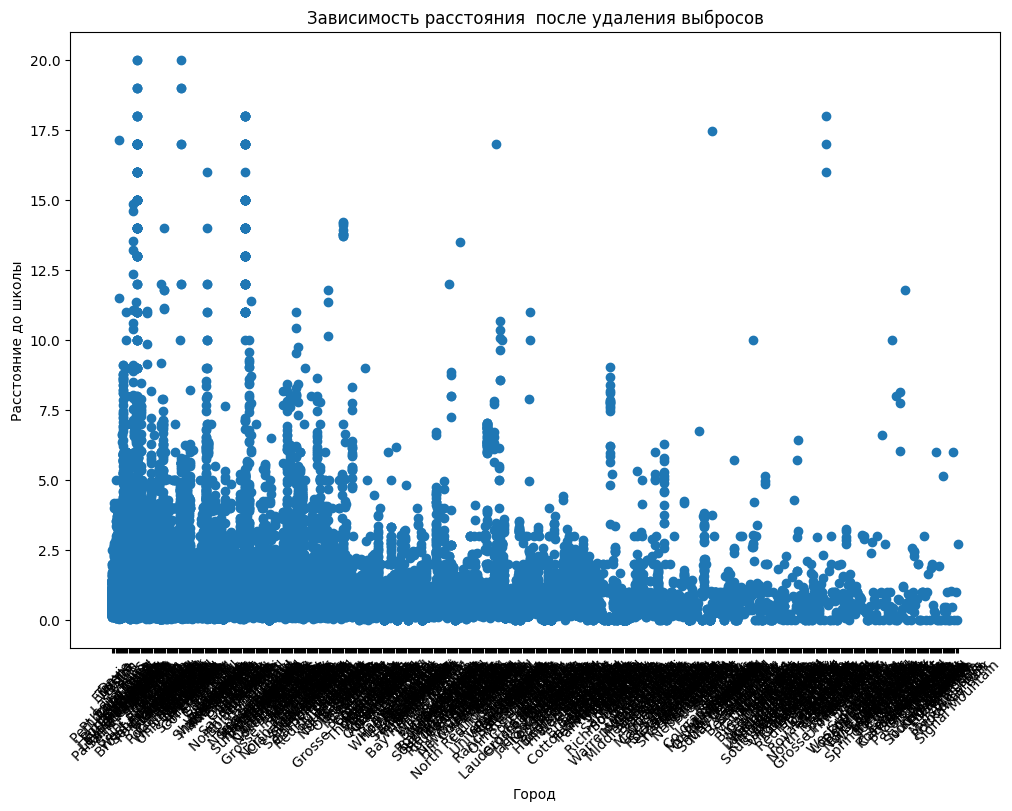

In [688]:
# Визуализация зависимости расстояния от города после удаления выбросов
plt.figure(figsize=(12, 8))
plt.scatter(df['city'], df['closest_distance'])
plt.xlabel('Город')
plt.ylabel('Расстояние до школы')
plt.title('Зависимость расстояния  после удаления выбросов')
plt.xticks(rotation=45)
plt.show()

In [689]:
Q1 = df['closest_distance'].quantile(0.25)
Q3 = df['closest_distance'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3* IQR

outliers = df[(df['closest_distance'] < lower_bound) | (df['closest_distance'] > upper_bound)]
cleaned = df[(df['closest_distance'] >= lower_bound) & (df['closest_distance'] <= upper_bound)]
df=cleaned
print(f'Число выбросов по методу IQR: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу IQR: 1828
Результирующее число записей: 56065


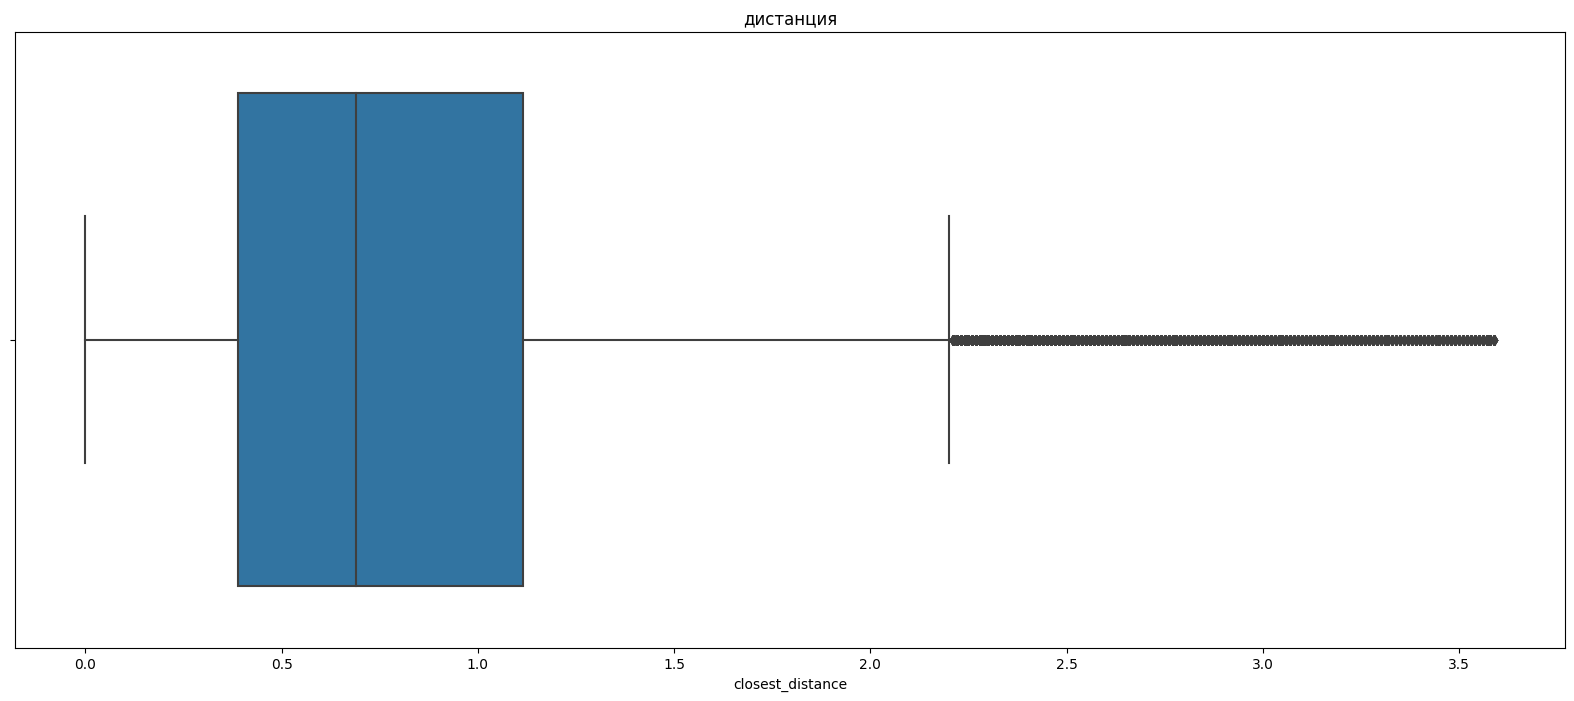

In [690]:
axes = plt.subplots(figsize=(20, 8))
boxplot = sns.boxplot(data=df, x='closest_distance', ax=axes[1])
boxplot.set_title('дистанция')
plt.show()

In [691]:
df['closest_distance'] = df['closest_distance'].astype(int)

столбец status

In [692]:
# Создаем словарь для соответствия ключевых слов к категориям
df['status'] = df['status'].astype(str)
df['status'] = df['status'].str.lower()#  значения в нижний регистр 
keyword_mapping = {
    'foreclosed': ['Foreclosure', 'foreclosure', 'Foreclosed'],
    'contract': ['Under Contract', 'Under Contract Backups', 'Active Under Contract',
                  'C',  'Contract Contingent On Buyer Sale',
                 'U Under Contract',  'Contract P','C Continue Show',
                 'C Continue Show',  'Active With Offer'],
    'pending': ['Pending', 'P', 'Pi','Pending Taking Backups','Pending Continue To Show', 'Pi','Pending With Contingencies',
                'Pending Taking Backups', 'P Pending Sale','Pending With Contingencies',  'Pending With Contingencies'],
    'inspection': ['inspection', 'active auction'],
    'coming soon': ['Coming soon','Coming soon:'],
    'for sale': ['for sale', 'For sale'],
    'cooling off period': ['recently sold','cooling off period']
}

# Создаем функцию для применения категорий в зависимости от ключевых слов
def assign_category(status):
    for category, keywords in keyword_mapping.items():
        for keyword in keywords:
            if status and keyword in status:
                return category
    return "Unknown"

# Применяем функцию assign_category для создания нового столбца "category"
df['status'] = df['status'].apply(assign_category)

In [693]:
df['status'].value_counts()

for sale      54279
foreclosed     1587
Unknown         199
Name: status, dtype: int64

In [694]:
null_values = df['status'].isnull().sum()
zero_values = len(df[df['status'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 0
Количество нулевых значений: 0


столбец propertyType

In [695]:
null_values = df['propertyType'].isnull().sum()
zero_values = len(df[df['propertyType'] == 0])
print(f"Количество пропущенных значений: {null_values}")
print(f"Количество нулевых значений: {zero_values}")

Количество пропущенных значений: 0
Количество нулевых значений: 0


In [696]:
property_mapping = {
    'Single Family Home': 'single home',
    'single-family home': 'single home',
    'townhouse': 'townhouse',
    'Single Family': 'single home',
    'coop': 'condo',
    'multi-family': 'condo',
    'Multi-Family Home': 'condo',
    'Condo': 'condo',
    'condo': 'condo',
    'Townhouse': 'townhouse',
    'lot/land': 'lot/land',
    'mobile/manufactured': 'manufactured',
    'Condo/Townhome/Row Home/Co-Op': 'multiple occupancy',
    'Multi Family': 'multiple occupancy',
    'Cooperative': 'condo',
    'Mobile / Manufactured': 'manufactured',
    'Mfd/Mobile Home': 'manufactured',
    'apartment': 'condo',
    'Farms/Ranches': 'farms/ranches',
    'Apartment': 'condo',
    'apartment/condo/townhouse': 'multiple occupancy',
    'unknown': 'unknown',
    'Miscellaneous': 'multiple occupancy',
    'Multiple Occupancy': 'multiple occupancy'  
}

df['propertyType'] = df['propertyType'].map(property_mapping)

In [697]:
df['propertyType']=df['propertyType'].fillna('unknown')

In [698]:
df['propertyType'].value_counts()

single home           41418
condo                 10290
townhouse              3476
manufactured            503
lot/land                244
multiple occupancy      129
unknown                   5
Name: propertyType, dtype: int64

In [699]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56065 entries, 12 to 377182
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status            56065 non-null  object 
 1   propertyType      56065 non-null  object 
 2   street            56065 non-null  object 
 3   baths             56065 non-null  object 
 4   fireplace         56065 non-null  int64  
 5   city              56065 non-null  object 
 6   schools           56065 non-null  object 
 7   sqft              56065 non-null  int64  
 8   zipcode           56065 non-null  int32  
 9   beds              56065 non-null  object 
 10  state             56065 non-null  object 
 11  target            56065 non-null  float64
 12  street_category   56065 non-null  object 
 13  Year built        56065 non-null  int32  
 14  Remodeled year    56065 non-null  int32  
 15  Heating           56065 non-null  int64  
 16  Cooling           56065 non-null  int6

In [700]:
# удалим технические столбцы
df=df.drop(['street','baths','baths_from_beds','beds','beds_from_beds','beds','Lot size','Price_sgu_clean','Grades','average_rating','schools'], axis=1)


In [701]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56065 entries, 12 to 377182
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status            56065 non-null  object 
 1   propertyType      56065 non-null  object 
 2   fireplace         56065 non-null  int64  
 3   city              56065 non-null  object 
 4   sqft              56065 non-null  int64  
 5   zipcode           56065 non-null  int32  
 6   state             56065 non-null  object 
 7   target            56065 non-null  float64
 8   street_category   56065 non-null  object 
 9   Year built        56065 non-null  int32  
 10  Remodeled year    56065 non-null  int32  
 11  Heating           56065 non-null  int64  
 12  Cooling           56065 non-null  int64  
 13  Parking Category  56065 non-null  object 
 14  mls_id            56065 non-null  int64  
 15  privatepool       56065 non-null  int64  
 16  baths_new         56065 non-null  floa

In [702]:
# удалим неинформативные столбцы
df=df.drop(['state','status','zipcode'],axis=1)

In [703]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56065 entries, 12 to 377182
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   propertyType      56065 non-null  object 
 1   fireplace         56065 non-null  int64  
 2   city              56065 non-null  object 
 3   sqft              56065 non-null  int64  
 4   target            56065 non-null  float64
 5   street_category   56065 non-null  object 
 6   Year built        56065 non-null  int32  
 7   Remodeled year    56065 non-null  int32  
 8   Heating           56065 non-null  int64  
 9   Cooling           56065 non-null  int64  
 10  Parking Category  56065 non-null  object 
 11  mls_id            56065 non-null  int64  
 12  privatepool       56065 non-null  int64  
 13  baths_new         56065 non-null  float64
 14  rating_count      56065 non-null  int64  
 15  closest_distance  56065 non-null  int32  
dtypes: float64(2), int32(3), int64(7), obj

Отбор признаков

In [704]:
# поиск неинформативных признаков
low_information_cols = []
for col in df.columns:
    top_freq = df[col].value_counts(normalize=True).max()
    nunique_ratio = df[col].nunique() / df[col].count()
    
    if (top_freq > 0.90) or (nunique_ratio > 0.90):
        low_information_cols.append(col)
        
print(low_information_cols)

['mls_id']


Неинформативные признаки по уровню порога: 
0.95 - отсутствут
0.90 - ['mls_id']
0.85 - ['mls_id']
Предлагаю убрать, особой смысловой нагрузки в них нет.

In [705]:
df=df.drop(['mls_id'], axis=1)

C:\Users\1\AppData\Local\Temp\ipykernel_22596\2020244152.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


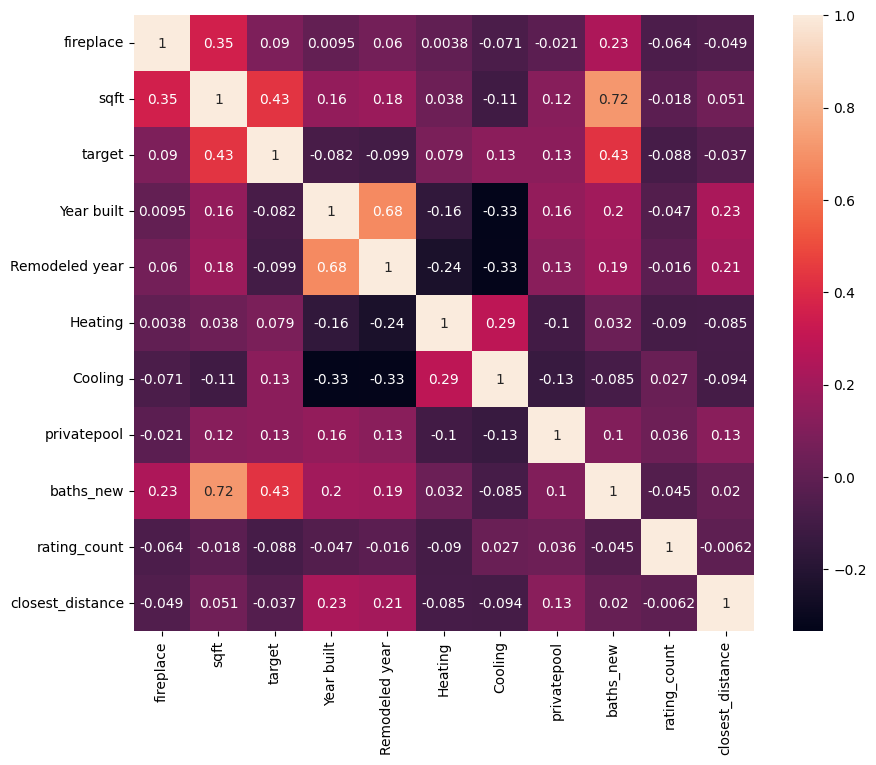

In [706]:
# зависимые признаки
plt.figure(figsize=(10, 8)) 
sns.heatmap(df.corr(), annot=True)
plt.show()

Зависимости: 
sqft&baths_new
Remodeled year&Year built
Решение:
1. удаляем столбец baths_new & Remodeled year


In [707]:

# удаляем столбцы
df=df.drop(['Cooling', 'Heating'], axis=1) 
df=df.drop(['baths_new','Remodeled year'], axis=1)


C:\Users\1\AppData\Local\Temp\ipykernel_22596\2020244152.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


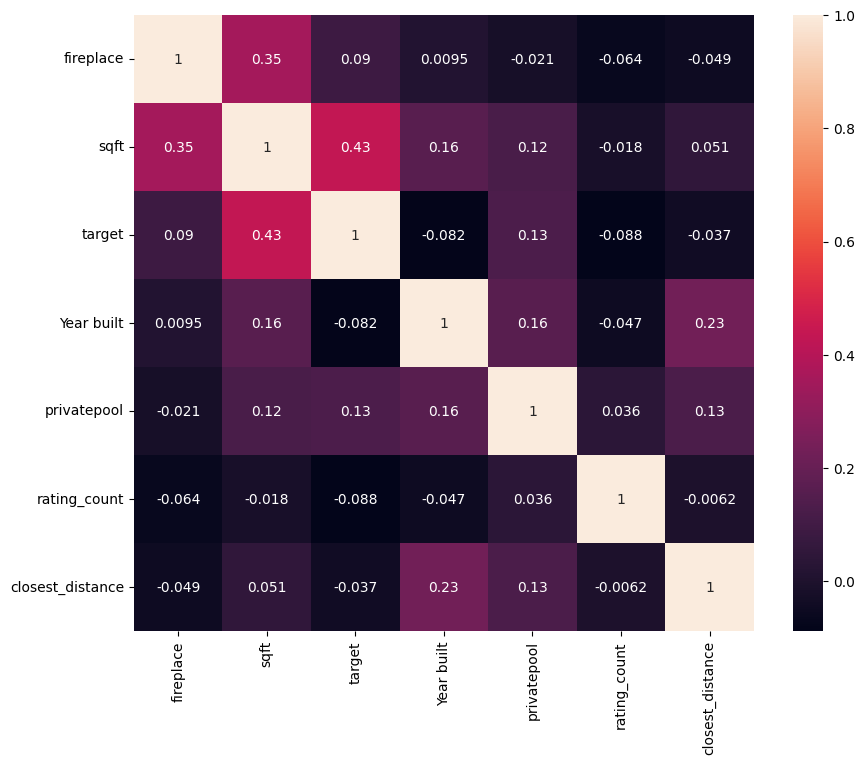

In [708]:
# зависимые признаки
plt.figure(figsize=(10, 8)) 
sns.heatmap(df.corr(), annot=True)
plt.show()

<AxesSubplot: xlabel='target', ylabel='sqft'>

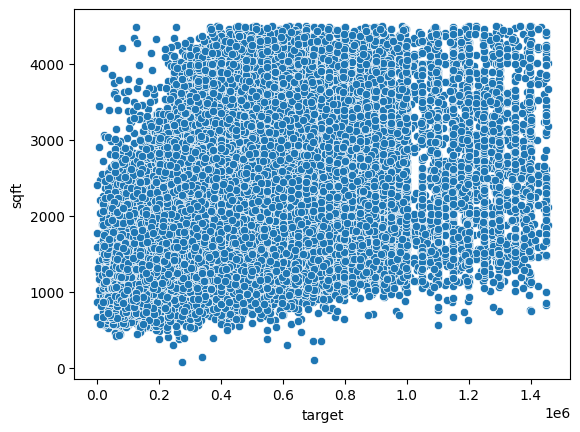

In [709]:
# зависимость между признакаами
sns.scatterplot(data=df, x="target", y="sqft")

Кодирование

In [710]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56065 entries, 12 to 377182
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   propertyType      56065 non-null  object 
 1   fireplace         56065 non-null  int64  
 2   city              56065 non-null  object 
 3   sqft              56065 non-null  int64  
 4   target            56065 non-null  float64
 5   street_category   56065 non-null  object 
 6   Year built        56065 non-null  int32  
 7   Parking Category  56065 non-null  object 
 8   privatepool       56065 non-null  int64  
 9   rating_count      56065 non-null  int64  
 10  closest_distance  56065 non-null  int32  
dtypes: float64(1), int32(2), int64(4), object(4)
memory usage: 4.7+ MB


In [711]:
# Parking Category
ohe_df = pd.get_dummies(df['Parking Category'], prefix='Parking Category')
# Объединяем исходный датафрейм и закодированный
df = pd.concat([df, ohe_df], axis=1)
df = df.drop(['Parking Category'], axis=1)

In [712]:
# street_category
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['street_category_encoded'] = encoder.fit_transform(df['street_category'])
df=df.drop(['street_category'],axis=1)

In [713]:
# city
df['city_encoded'] = encoder.fit_transform(df['city'])
df=df.drop(['city'],axis=1)

In [714]:
# property Type
propertyType_encoded = encoder.fit_transform(df['propertyType'])
propertyType_encoded = propertyType_encoded.ravel()
df = df.drop(['propertyType'], axis=1)

In [715]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56065 entries, 12 to 377182
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   fireplace                      56065 non-null  int64  
 1   sqft                           56065 non-null  int64  
 2   target                         56065 non-null  float64
 3   Year built                     56065 non-null  int32  
 4   privatepool                    56065 non-null  int64  
 5   rating_count                   56065 non-null  int64  
 6   closest_distance               56065 non-null  int32  
 7   Parking Category_Garage        56065 non-null  uint8  
 8   Parking Category_No Parking    56065 non-null  uint8  
 9   Parking Category_Restrictions  56065 non-null  uint8  
 10  street_category_encoded        56065 non-null  int32  
 11  city_encoded                   56065 non-null  int32  
dtypes: float64(1), int32(4), int64(4), uint8(3)


Нормализация 

столбец sqft

In [716]:
# Проверка нормальности о признака
from scipy.stats import anderson

# Проверка нормальности признака 'zipcode'
result = anderson(df['sqft'])
statistic = result.statistic
critical_values = result.critical_values
alpha = 0.05

if statistic < critical_values[2]:
    print("Целевой признак имеет нормальное распределение")
else:
    print("Целевой признак не имеет нормальное распределение")

Целевой признак не имеет нормальное распределение


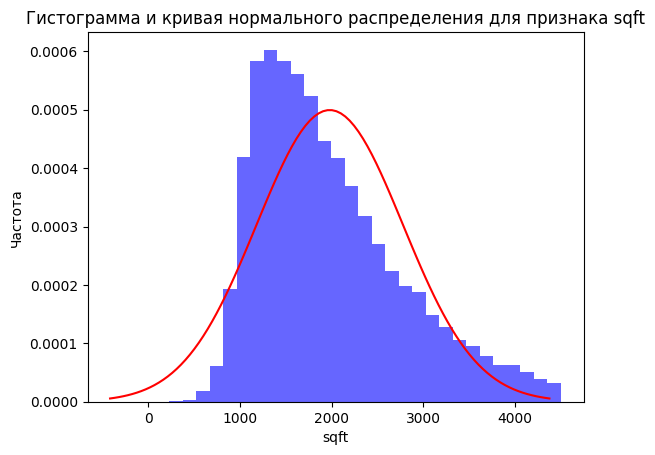

In [717]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Создание гистограммы для признака
plt.hist(df['sqft'], bins=30, density=True, alpha=0.6, color='b')

# Генерация значения среднего и стандартного отклонения
mu, sigma = np.mean(df['sqft']), np.std(df['sqft'])

# Создание кривой нормального распределения на основе среднего и стандартного отклонения
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r')

# Вывод графика
plt.xlabel('sqft')
plt.ylabel('Частота')
plt.title('Гистограмма и кривая нормального распределения для признака sqft')
plt.show()

In [718]:
# нормализация
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df['sqft_normalized'] = scaler.fit_transform(df['sqft'].values.reshape(-1, 1))
print(df['sqft_normalized'])

12        0.971028
13        0.018692
28        0.513084
31       -0.114953
32       -0.583178
            ...   
377165   -0.188785
377172    0.100000
377173    0.658879
377175   -0.007477
377182   -0.605607
Name: sqft_normalized, Length: 56065, dtype: float64


столбец target

In [719]:
result = anderson(df['target'])
statistic = result.statistic
critical_values = result.critical_values
alpha = 0.05

if statistic < critical_values[2]:
    print("Целевой признак имеет нормальное распределение")
else:
    print("Целевой признак не имеет нормальное распределение")

Целевой признак не имеет нормальное распределение


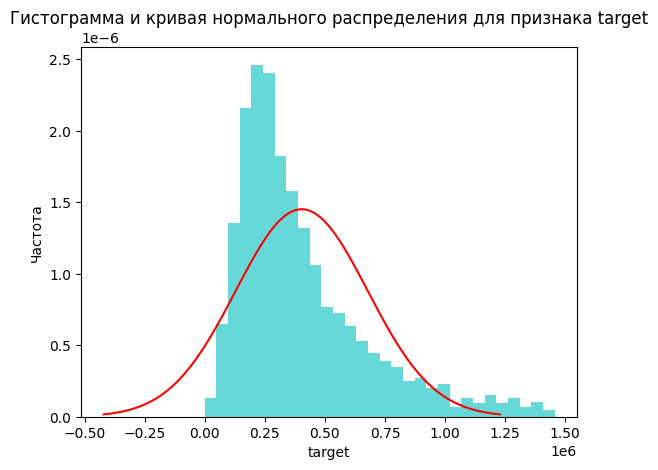

In [720]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Создание гистограммы для признака
plt.hist(df['target'], bins=30, density=True, alpha=0.6, color='c')

# Генерация значения среднего и стандартного отклонения
mu, sigma = np.mean(df['target']), np.std(df['target'])

# Создание кривой нормального распределения на основе среднего и стандартного отклонения
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r')

# Вывод графика
plt.xlabel('target')
plt.ylabel('Частота')
plt.title('Гистограмма и кривая нормального распределения для признака target')
plt.show()

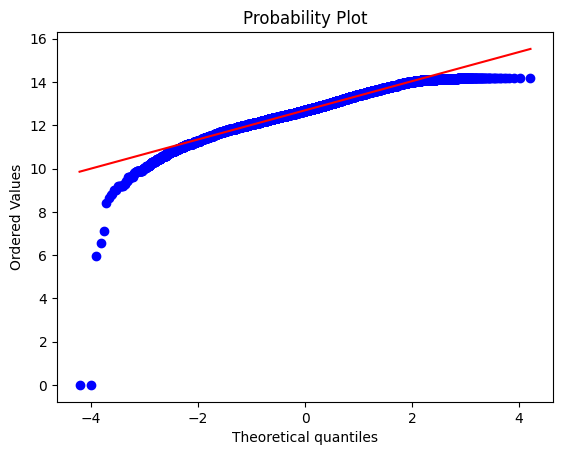

In [721]:
# логарифмическое преобразование к столбцу 'target'
df['target_transformed'] = np.log(df['target'])

# Проверить новое распределение
stats.probplot(df['target_transformed'], dist="norm", plot=plt)
plt.show()

In [722]:
# Проверка нормальности целевого признака
result = anderson(df['target'])
statistic = result.statistic
critical_values = result.critical_values
alpha = 0.05

if statistic < critical_values[2]:
    print("Целевой признак имеет нормальное распределение")
else:
    print("Целевой признак не имеет нормальное распределение")

Целевой признак не имеет нормальное распределение


In [723]:
# нормализация
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df['target_normalized'] = scaler.fit_transform(df['target'].values.reshape(-1, 1))
print(df['target_normalized'])

12        0.669932
13        0.587907
28        0.781043
31       -0.189542
32       -0.376469
            ...   
377165   -0.016340
377172   -0.104578
377173    0.212091
377175   -0.130719
377182    0.679736
Name: target_normalized, Length: 56065, dtype: float64


столбец Year built

In [724]:
# проверка на нормальность 

result = anderson(df['Year built'])
statistic = result.statistic
critical_values = result.critical_values
alpha = 0.05

if statistic < critical_values[2]:
    print("Целевой признак имеет нормальное распределение")
else:
    print("Целевой признак не имеет нормальное распределение")

Целевой признак не имеет нормальное распределение


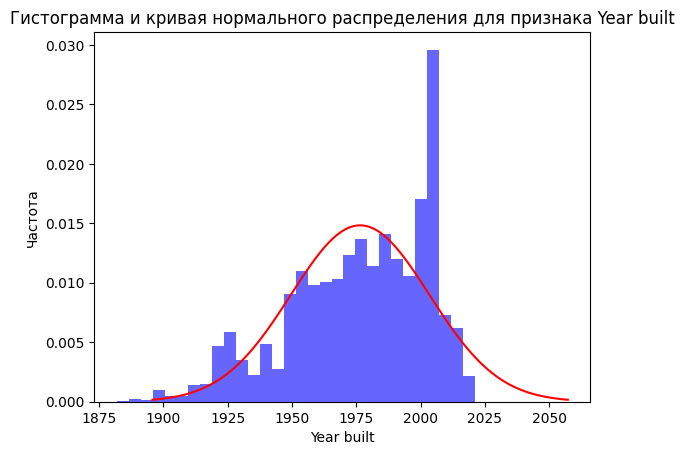

In [725]:
# Создание гистограммы для признака
plt.hist(df['Year built'], bins=30, density=True, alpha=0.6, color='b')

# Генерация значения среднего и стандартного отклонения
mu, sigma = np.mean(df['Year built']), np.std(df['Year built'])

# Создание кривой нормального распределения на основе среднего и стандартного отклонения
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r')

# Вывод графика
plt.xlabel('Year built')
plt.ylabel('Частота')
plt.title('Гистограмма и кривая нормального распределения для признака Year built')
plt.show()

In [726]:
# нормализация
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df['year_built_normalized'] = scaler.fit_transform(df['Year built'].values.reshape(-1, 1))
print(df['year_built_normalized'])


12        0.390244
13        0.951220
28        0.341463
31       -0.487805
32       -0.073171
            ...   
377165    0.292683
377172   -0.268293
377173   -0.731707
377175   -0.243902
377182   -0.731707
Name: year_built_normalized, Length: 56065, dtype: float64


столбец rating_count

In [727]:
# проверка на нормальность 

result = anderson(df['rating_count'])
statistic = result.statistic
critical_values = result.critical_values
alpha = 0.05

if statistic < critical_values[2]:
    print("Целевой признак имеет нормальное распределение")
else:
    print("Целевой признак не имеет нормальное распределение")

Целевой признак не имеет нормальное распределение


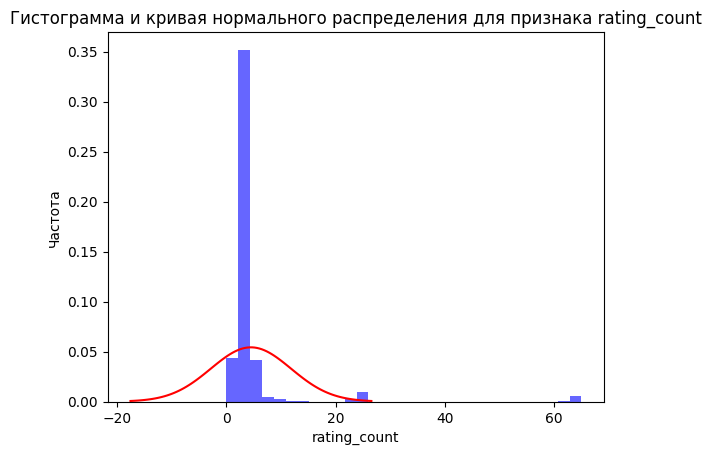

In [728]:
# Создание гистограммы для признака
plt.hist(df['rating_count'], bins=30, density=True, alpha=0.6, color='b')

# Генерация значения среднего и стандартного отклонения
mu, sigma = np.mean(df['rating_count']), np.std(df['rating_count'])

# Создание кривой нормального распределения на основе среднего и стандартного отклонения
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r')

# Вывод графика
plt.xlabel('rating_count')
plt.ylabel('Частота')
plt.title('Гистограмма и кривая нормального распределения для признака rating_count')
plt.show()

In [729]:
# нормализация
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df['rating_count_normalized'] = scaler.fit_transform(df['rating_count'].values.reshape(-1, 1))
print(df['rating_count_normalized'])

12        0.0
13        0.0
28        0.0
31        0.0
32        7.0
         ... 
377165    0.0
377172    0.0
377173    0.0
377175    0.0
377182   -1.0
Name: rating_count_normalized, Length: 56065, dtype: float64


столбец closest_distance

In [730]:
# проверка на нормальность 

result = anderson(df['closest_distance'])
statistic = result.statistic
critical_values = result.critical_values
alpha = 0.05

if statistic < critical_values[2]:
    print("Целевой признак имеет нормальное распределение")
else:
    print("Целевой признак не имеет нормальное распределение")

Целевой признак не имеет нормальное распределение


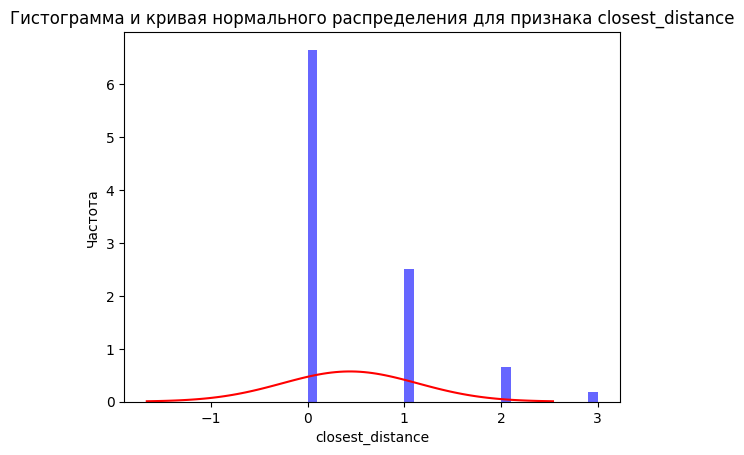

In [731]:
# Создание гистограммы для признака
plt.hist(df['closest_distance'], bins=30, density=True, alpha=0.6, color='b')

# Генерация значения среднего и стандартного отклонения
mu, sigma = np.mean(df['closest_distance']), np.std(df['closest_distance'])

# Создание кривой нормального распределения на основе среднего и стандартного отклонения
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r')

# Вывод графика
plt.xlabel('closest_distance')
plt.ylabel('Частота')
plt.title('Гистограмма и кривая нормального распределения для признака closest_distance')
plt.show()

In [732]:
# нормализация
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df['closest_distance_normalized'] = scaler.fit_transform(df['closest_distance'].values.reshape(-1, 1))
print(df['closest_distance_normalized'])

12        0.0
13        1.0
28        0.0
31        2.0
32        1.0
         ... 
377165    0.0
377172    0.0
377173    1.0
377175    0.0
377182    0.0
Name: closest_distance_normalized, Length: 56065, dtype: float64


столбец privatepool

In [733]:
# проверка на нормальность 

result = anderson(df['privatepool'])
statistic = result.statistic
critical_values = result.critical_values
alpha = 0.05

if statistic < critical_values[2]:
    print("Целевой признак имеет нормальное распределение")
else:
    print("Целевой признак не имеет нормальное распределение")

Целевой признак не имеет нормальное распределение


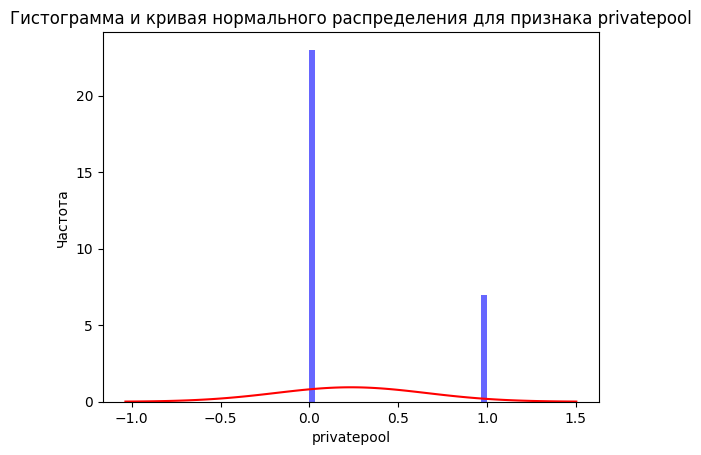

In [734]:
# Создание гистограммы для признака
plt.hist(df['privatepool'], bins=30, density=True, alpha=0.6, color='b')

# Генерация значения среднего и стандартного отклонения
mu, sigma = np.mean(df['privatepool']), np.std(df['privatepool'])

# Создание кривой нормального распределения на основе среднего и стандартного отклонения
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r')

# Вывод графика
plt.xlabel('privatepool')
plt.ylabel('Частота')
plt.title('Гистограмма и кривая нормального распределения для признака privatepool')
plt.show()

In [735]:
# нормализация
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df['privatepool_normalized'] = scaler.fit_transform(df['privatepool'].values.reshape(-1, 1))
print(df['privatepool_normalized'])

12        1.0
13        0.0
28        0.0
31        0.0
32        0.0
         ... 
377165    0.0
377172    0.0
377173    0.0
377175    0.0
377182    0.0
Name: privatepool_normalized, Length: 56065, dtype: float64


In [736]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56065 entries, 12 to 377182
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   fireplace                      56065 non-null  int64  
 1   sqft                           56065 non-null  int64  
 2   target                         56065 non-null  float64
 3   Year built                     56065 non-null  int32  
 4   privatepool                    56065 non-null  int64  
 5   rating_count                   56065 non-null  int64  
 6   closest_distance               56065 non-null  int32  
 7   Parking Category_Garage        56065 non-null  uint8  
 8   Parking Category_No Parking    56065 non-null  uint8  
 9   Parking Category_Restrictions  56065 non-null  uint8  
 10  street_category_encoded        56065 non-null  int32  
 11  city_encoded                   56065 non-null  int32  
 12  sqft_normalized                56065 non-nul

In [737]:
data_norm=df.copy()

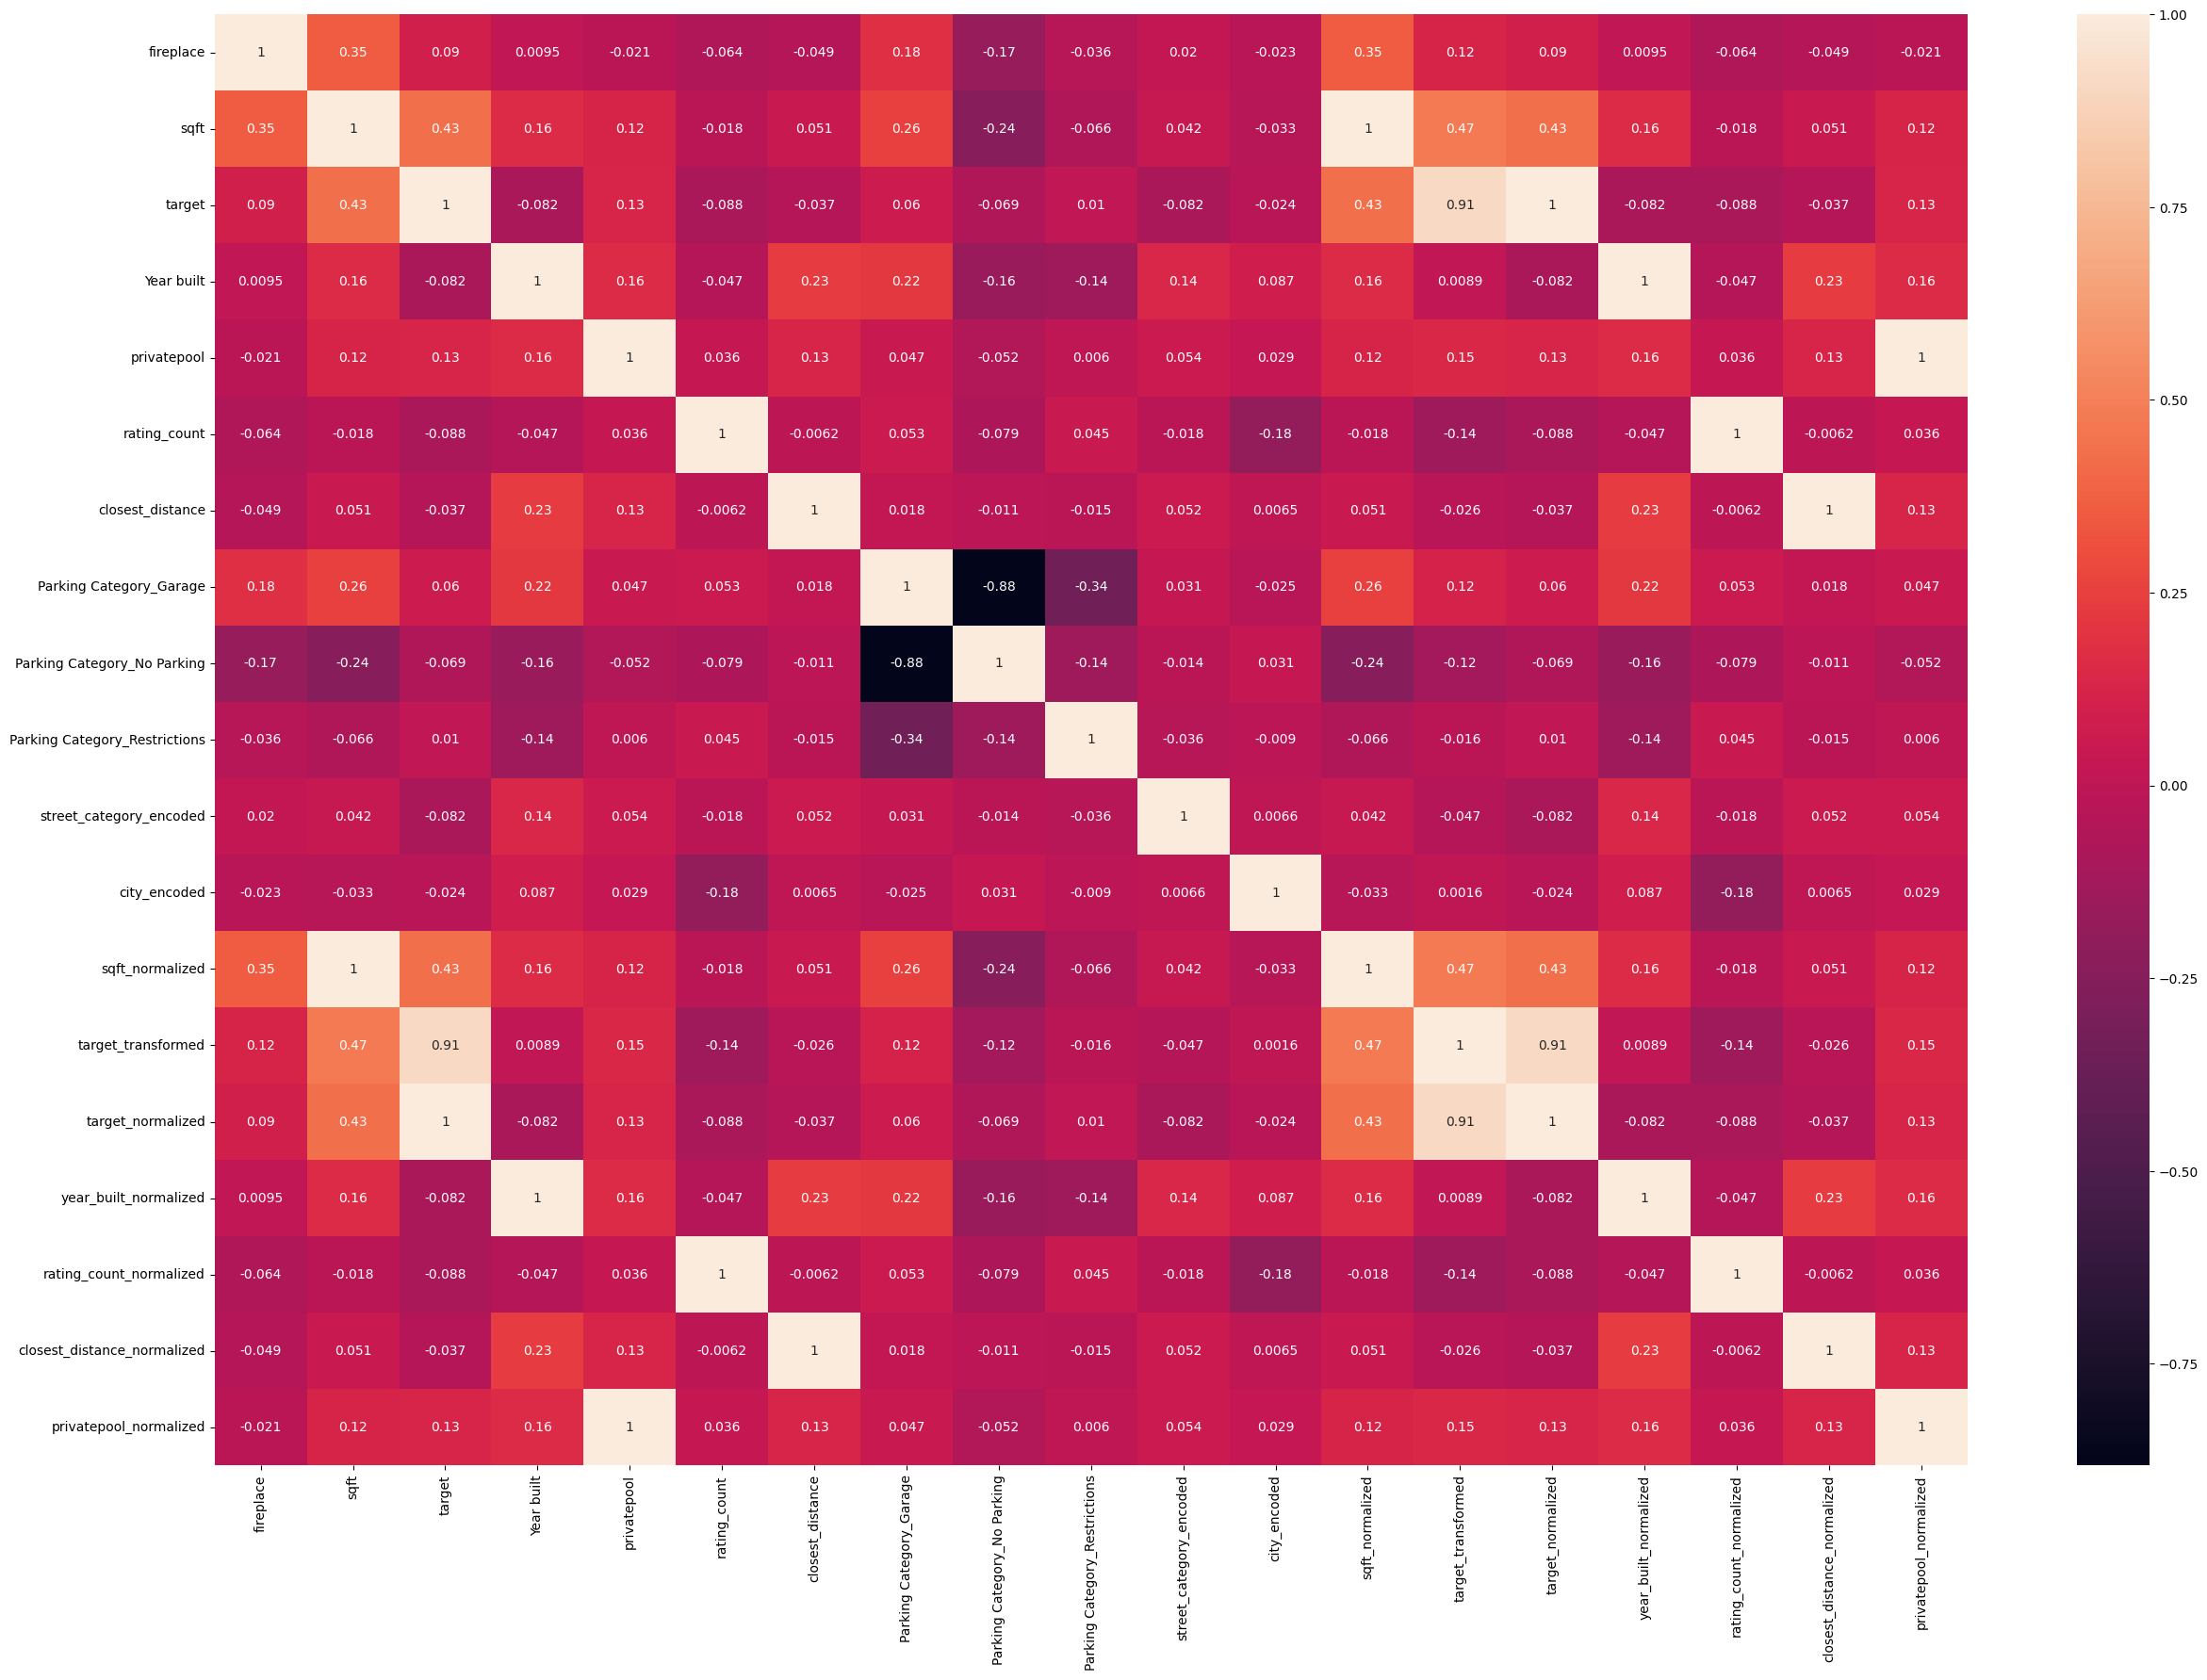

In [738]:
# зависимые признаки
plt.figure(figsize=(30, 20)) 
sns.heatmap(df.corr(), annot=True)
plt.show()

In [739]:
# поиск неинформативных признаков
low_information_cols = []
for col in df.columns:
    top_freq = df[col].value_counts(normalize=True).max()
    nunique_ratio = df[col].nunique() / df[col].count()
    
    if (top_freq > 0.95) or (nunique_ratio > 0.95):
        low_information_cols.append(col)
        
print(low_information_cols)

[]


In [740]:
# выявим наиболее значимые признаки
import statsmodels.api as sm
X = df.drop('target', axis=1)
y = df['target']
# Добавляем константу к признакам
X = sm.add_constant(X)
# Создаем модель
model = sm.OLS(y, X)
# получаем результаты
results = model.fit()
# Выводим общую сводку
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.574e+29
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:05:35   Log-Likelihood:             8.8900e+05
No. Observations:               56065   AIC:                        -1.778e+06
Df Residuals:                   56052   BIC:                        -1.778e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Наиболее значимыми признаками в данной модели являются:
- sqft 
- Year built 
- rating_count 
- Parking Category_Garage 
- Parking Category_No Parking 
- Parking Category_Restrictions 
- street_category_encoded 
- city_encoded 
- sqft_normalized 
- year_built_normalized 
- rating_count_normalized 
- target_normalized 

In [741]:
from scipy.stats import pearsonr

# Проведите корреляционный тест
corr, p_value = pearsonr(df['target'], df['sqft'])

print(f"Корреляция: {corr}")
print(f"p-значение: {p_value}")

Корреляция: 0.4336391034762923
p-значение: 0.0


In [742]:
from scipy.stats import f_oneway
   
# Проведение теста ANOVA для зависимости между целевым признаком и статусом
groups = df.groupby('sqft')['target'].apply(list)
stat, p = f_oneway(*groups)
alpha = 0.05
if p < alpha:
    print("Существует статистически значимая зависимость между целевым признаком и площадью")
else:
    print("Нет статистически значимой зависимости между целевым признаком и площадью")


Существует статистически значимая зависимость между целевым признаком и площадью


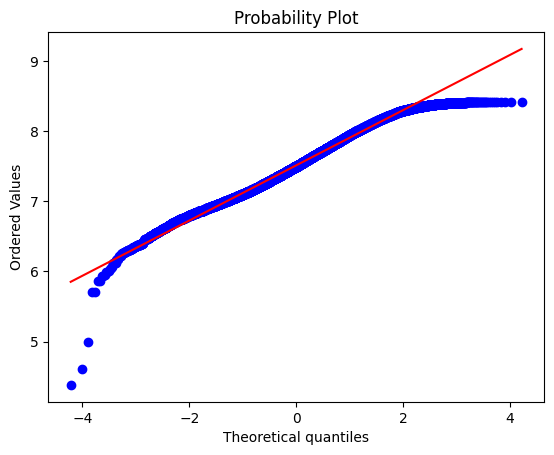

In [743]:
# логарифмическое преобразование к столбцу 'sqft'
df['sqft_transformed'] = np.log(df['sqft'])

# Проверить новое распределение
stats.probplot(df['sqft_transformed'], dist="norm", plot=plt)
plt.show()

Моделирование

In [744]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=42)

# Создание объекта модели градиентного бустинга
model = xgb.XGBRegressor()

# Обучение модели на обучающей выборке
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Оценка качества модели по среднеквадратичной ошибке
mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка: {mse}")

Среднеквадратичная ошибка: 16312669.635959806


In [745]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Разделение данных на признаки и целевой признак
X = df.drop('target', axis=1)
y = df['target']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание объекта модели случайного леса
model = RandomForestRegressor()

# Обучение модели
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Оценка качества модели с помощью средней квадратичной ошибки
mse = mean_squared_error(y_test, y_pred)
print('Ошибка модели: ', mse)

Ошибка модели:  12226.291054392146


In [746]:
from sklearn.feature_selection import SelectKBest, f_regression

# количество лучших переменных
k = 12

# Создаем объект SelectKBest и указываем метрику для оценки переменных (f_regression для регрессии)
selector = SelectKBest(score_func=f_regression, k=k)

#  делим признаки и целевую переменную
X = df.drop(columns=['target'])
y = df['target']

#  отбор лучших переменных
X_new = selector.fit_transform(X, y)

#  список лучших переменных
feature_names = X.columns[selector.get_support(indices=True)]

#  названия лучших переменных
print("Названия лучших переменных:", feature_names)

Названия лучших переменных: Index(['fireplace', 'sqft', 'Year built', 'privatepool', 'rating_count',
       'street_category_encoded', 'sqft_normalized', 'target_transformed',
       'year_built_normalized', 'rating_count_normalized',
       'privatepool_normalized', 'sqft_transformed'],
      dtype='object')


In [747]:
# Метод рекурсивного исключения признаков (RFE)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression 
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=12, step=1)
selector = selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['fireplace', 'privatepool', 'rating_count', 'closest_distance',
       'Parking Category_Garage', 'Parking Category_No Parking',
       'sqft_normalized', 'target_transformed', 'target_normalized',
       'rating_count_normalized', 'closest_distance_normalized',
       'privatepool_normalized'], dtype=object)

In [748]:
SelectBest=['fireplace', 'sqft', 'Year built', 'privatepool', 'rating_count',
       'street_category_encoded', 'sqft_normalized', 'target_transformed',
       'year_built_normalized', 'rating_count_normalized',
       'privatepool_normalized', 'sqft_transformed'] 
RFE=['fireplace', 'privatepool', 'rating_count', 'closest_distance',
       'Parking Category_Garage', 'Parking Category_No Parking',
       'sqft_normalized', 'target_transformed', 'target_normalized',
       'rating_count_normalized', 'closest_distance_normalized',
       'privatepool_normalized']
# совпадения
intersection = list(set(SelectBest) & set(RFE))
print("Совпадения:", intersection)

#различия в SelectBest
difference_SelectBest = list(set(SelectBest) - set(RFE))
print("Различия в SelectBest:", difference_SelectBest)

# различия в RFE
difference_RFE = list(set(RFE) - set(SelectBest))
print("Различия в RFE:", difference_RFE)

Совпадения: ['fireplace', 'rating_count_normalized', 'privatepool_normalized', 'sqft_normalized', 'target_transformed', 'privatepool', 'rating_count']
Различия в SelectBest: ['sqft_transformed', 'Year built', 'sqft', 'street_category_encoded', 'year_built_normalized']
Различия в RFE: ['Parking Category_No Parking', 'Parking Category_Garage', 'closest_distance_normalized', 'closest_distance', 'target_normalized']


In [749]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Разделение данных на признаки и целевой признак
X = df.drop('target', axis=1)
y = df['target']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание объекта модели линейной регрессии
model = LinearRegression()

# Обучение модели
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Оценка качества модели с помощью средней квадратичной ошибки
mse = mean_squared_error(y_test, y_pred)
print('Ошибка модели: ', mse)

Ошибка модели:  1.3776797655103405e-17


In [750]:
# Импортирование необходимых библиотек
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = df.drop(columns=['target'])
y = df['target']


# Разделение датасета на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Создание и обучение модели дерева принятия решений
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Прогнозирование классов для тестовой выборки
y_pred = clf.predict(X_test)
# Оценка точности модели
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Точность модели:", accuracy)

# Оценка полноты модели
recall = metrics.recall_score(y_test, y_pred, average='macro')
print("Полнота модели:", recall)

# Оценка точности модели
precision = metrics.precision_score(y_test, y_pred, average='macro')
print("Точность модели:", precision)

# Оценка F-меры модели
f1_score = metrics.f1_score(y_test, y_pred, average='macro')
print("F-мера модели:", f1_score)


Точность модели: 0.9079667063020214
Полнота модели: 0.43616970935272165
Точность модели: 0.417077249391116
F-мера модели: 0.42038839413424384


c:\Users\1\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\1\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
